In [1]:
import pandas as pd
import numpy as np
import os
from scipy.stats import spearmanr
from tqdm.notebook import tqdm
from joblib import Parallel, delayed

In [2]:
!module load texlive
import matplotlib.pyplot as plt
import os

os.environ['PATH'] = "/software/texlive/2020/bin/x86_64-linux:" + os.environ['PATH']

matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['axes.labelsize'] = 24
matplotlib.rcParams['legend.fontsize'] = 24
matplotlib.rcParams['axes.titlesize'] = 24
matplotlib.rcParams['xtick.labelsize'] = 24
matplotlib.rcParams['ytick.labelsize'] = 24

# Code to analyze parameter scan


In [3]:
param_df = pd.read_csv('/home/mzo5929/Keerthana/grnInference/simulationData/parameter_sweep.csv', index_col=0)

In [4]:
def find_csv_files(folder_path):
    csv_files = []
    for item in os.listdir(folder_path):
        if item.endswith(".csv"):
            csv_files.append(item)
    return csv_files

In [5]:
# Helper function for correlation
def compute_diff_correlation(rep1, rep2):
    diff_tf = rep1['total_TF_mRNA'].values - rep2['total_TF_mRNA'].values
    diff_target = rep1['total_Target_mRNA'].values - rep2['total_Target_mRNA'].values
    return spearmanr(diff_tf, diff_target)[0]

# Compute correlations at a time point
def get_correlations(df, time):
    df = df[df['sampling_time'] == time].reset_index(drop=True)
    corr_gene_gene = spearmanr(df['total_TF_mRNA'], df['total_Target_mRNA'])[0]

    rep1 = df[df['replicate'] == 0].reset_index(drop=True)
    rep2 = df[df['replicate'] == 1].reset_index(drop=True)

    corr_twin_pair = compute_diff_correlation(rep1, rep2)
    rep2_random = rep2.sample(frac=1, random_state=0, ignore_index=True)
    corr_random_pair = compute_diff_correlation(rep1, rep2_random)

    return corr_gene_gene, corr_twin_pair, corr_random_pair

# Parallelized task per simulation
def process_simulation_single_population(sim, path_to_folder, parameter_of_interest, t1, t2):
    sim_path = os.path.join(path_to_folder, sim)
    population = pd.read_csv(sim_path)

    param_value = sim.split('_param_index_')[1].split('_')[0]
    run_number = sim.split('_run_')[1].split('_')[0]
    parameter_value = param_df.loc[int(param_value)][parameter_of_interest]

    c1, c2, c3 = get_correlations(population, t1)
    c4, c5, c6 = get_correlations(population, t2)

    return {
        f'{parameter_of_interest}': parameter_value,
        'run': run_number,
        't1_gene_gene_correlation': c1,
        't1_twin_pair_correlation': c2,
        't1_random_pair_correlation': c3,
        't2_gene_gene_correlation': c4,
        't2_twin_pair_correlation': c5,
        't2_random_pair_correlation': c6,
    }

# Parallelized task per simulation
def process_simulation_mixed_population(sim, constant_pop, path_to_folder, parameter_of_interest, t1, t2):
    sim_path = os.path.join(path_to_folder, sim)
    current_pop = pd.read_csv(sim_path)
    population = pd.concat([current_pop, constant_pop], axis=0)
    
    param_value = sim.split('_param_index_')[1].split('_')[0]
    run_number = sim.split('_run_')[1].split('_')[0]
    parameter_value = param_df.loc[int(param_value)][parameter_of_interest]

    c1, c2, c3 = get_correlations(population, t1)
    c4, c5, c6 = get_correlations(population, t2)

    return {
        f'{parameter_of_interest}': parameter_value,
        'run': run_number,
        't1_gene_gene_correlation': c1,
        't1_twin_pair_correlation': c2,
        't1_random_pair_correlation': c3,
        't2_gene_gene_correlation': c4,
        't2_twin_pair_correlation': c5,
        't2_random_pair_correlation': c6,
    }




In [6]:
# params = mrna_half_life_TF,mrna_half_life_Target,protein_half_life,protein_production_rate,labeling_efficiency,pulse_time,num_cells,dynamics,capture_efficiency

#Plot the mean and standard deviation of each group and colour between the 2 standard deviations
def plot_and_save(parameter_of_interest, correlation_df_grouped_t1, regulation = True, lim = 0.2):
    #split the parameter of interest by "_"
    parameter_of_interest_split = parameter_of_interest.split("_")
    if parameter_of_interest_split[0] == "k":
        parameter_label = rf'$k_{{{parameter_of_interest_split[1]}}}^{{{parameter_of_interest_split[2]}}}$'
    elif parameter_of_interest_split[0] == "burst":
        parameter_label = rf'$Burst-size_{{{parameter_of_interest_split[-1]}}}$'
    elif parameter_of_interest_split[0] == "mrna":
        parameter_label = rf'$mRNA-halflife_{{{parameter_of_interest_split[-1]}}}$'
    else:
        parameter_label = rf'${parameter_of_interest}$'

    plt.figure(figsize=(10, 5))
    plt.errorbar(correlation_df_grouped_t1[parameter_of_interest], correlation_df_grouped_t1['t1_gene_gene_correlation']['mean'], yerr=correlation_df_grouped_t1['t1_gene_gene_correlation']['std'], fmt='o', label=r'$\rho$')
    plt.fill_between(correlation_df_grouped_t1[parameter_of_interest], correlation_df_grouped_t1['t1_gene_gene_correlation']['mean'] - correlation_df_grouped_t1['t1_gene_gene_correlation']['std'], correlation_df_grouped_t1['t1_gene_gene_correlation']['mean'] + correlation_df_grouped_t1['t1_gene_gene_correlation']['std'], alpha=0.1, color='blue')
    plt.errorbar(correlation_df_grouped_t1[parameter_of_interest], correlation_df_grouped_t1['t1_twin_pair_correlation']['mean'], yerr=correlation_df_grouped_t1['t1_twin_pair_correlation']['std'], fmt='o', label=r'$\bar{\rho_{\Delta}}$')
    plt.fill_between(correlation_df_grouped_t1[parameter_of_interest], correlation_df_grouped_t1['t1_twin_pair_correlation']['mean'] - correlation_df_grouped_t1['t1_twin_pair_correlation']['std'], correlation_df_grouped_t1['t1_twin_pair_correlation']['mean'] + correlation_df_grouped_t1['t1_twin_pair_correlation']['std'], alpha=0.1, color='red')
    plt.errorbar(correlation_df_grouped_t1[parameter_of_interest], correlation_df_grouped_t1['t1_random_pair_correlation']['mean'], yerr=correlation_df_grouped_t1['t1_random_pair_correlation']['std'], fmt='o', label=r'$\rho_{\Delta}$')
    plt.fill_between(correlation_df_grouped_t1[parameter_of_interest], correlation_df_grouped_t1['t1_random_pair_correlation']['mean'] - correlation_df_grouped_t1['t1_random_pair_correlation']['std'], correlation_df_grouped_t1['t1_random_pair_correlation']['mean'] + correlation_df_grouped_t1['t1_random_pair_correlation']['std'], alpha=0.1, color='green')
  
    
    plt.xlabel(rf'{parameter_label}')
    plt.ylabel('Correlations')
    # plt.ylim(-0.01, 0.01)
    plt.ylim(-1*lim, 1*lim)
    # plt.yscale('log')
    plt.axhline(1e-3, color='black', linestyle='--', label=r'$\rho_{Baseline}$')
    plt.axhline(-1*1e-3, color='black', linestyle='--', label=r'$\rho_{Baseline}$')
    plt.title(rf'Correlations vs {parameter_label}')
    plt.legend(loc = 'upper right')
    #Save plot
    if regulation:
        plt.savefig(f'/home/mzo5929/Keerthana/grnInference/plots/param_scan2/correlation_plot_{parameter_of_interest.lower()}.svg', bbox_inches='tight')
        plt.savefig(f'/home/mzo5929/Keerthana/grnInference/plots/param_scan2/correlation_plot_{parameter_of_interest.lower()}.png', bbox_inches='tight')
        plt.show()
    else:
        plt.savefig(f'/home/mzo5929/Keerthana/grnInference/plots/param_scan2/correlation_plot_{parameter_of_interest.lower()}_no_regulation.svg', bbox_inches='tight')
        plt.savefig(f'/home/mzo5929/Keerthana/grnInference/plots/param_scan2/correlation_plot_{parameter_of_interest.lower()}_no_regulation.png', bbox_inches='tight')
        plt.show()

    if not regulation:
        plt.figure(figsize=(10, 5))
        plt.errorbar(correlation_df_grouped_t1[parameter_of_interest], correlation_df_grouped_t1['t1_gene_gene_correlation']['mean'], yerr=correlation_df_grouped_t1['t1_gene_gene_correlation']['std'], fmt='o', label=r'$\rho$')
        plt.fill_between(correlation_df_grouped_t1[parameter_of_interest], correlation_df_grouped_t1['t1_gene_gene_correlation']['mean'] - correlation_df_grouped_t1['t1_gene_gene_correlation']['std'], correlation_df_grouped_t1['t1_gene_gene_correlation']['mean'] + correlation_df_grouped_t1['t1_gene_gene_correlation']['std'], alpha=0.1, color='blue')
        plt.errorbar(correlation_df_grouped_t1[parameter_of_interest], correlation_df_grouped_t1['t1_twin_pair_correlation']['mean'], yerr=correlation_df_grouped_t1['t1_twin_pair_correlation']['std'], fmt='o', label=r'$\bar{\rho_{\Delta}}$')
        plt.fill_between(correlation_df_grouped_t1[parameter_of_interest], correlation_df_grouped_t1['t1_twin_pair_correlation']['mean'] - correlation_df_grouped_t1['t1_twin_pair_correlation']['std'], correlation_df_grouped_t1['t1_twin_pair_correlation']['mean'] + correlation_df_grouped_t1['t1_twin_pair_correlation']['std'], alpha=0.1, color='red')
        plt.errorbar(correlation_df_grouped_t1[parameter_of_interest], correlation_df_grouped_t1['t1_random_pair_correlation']['mean'], yerr=correlation_df_grouped_t1['t1_random_pair_correlation']['std'], fmt='o', label=r'$\rho_{\Delta}$')
        plt.fill_between(correlation_df_grouped_t1[parameter_of_interest], correlation_df_grouped_t1['t1_random_pair_correlation']['mean'] - correlation_df_grouped_t1['t1_random_pair_correlation']['std'], correlation_df_grouped_t1['t1_random_pair_correlation']['mean'] + correlation_df_grouped_t1['t1_random_pair_correlation']['std'], alpha=0.1, color='green')
        plt.xlabel(rf'{parameter_label}')
        plt.ylabel('Correlations')
        plt.ylim(-0.01, 0.01)
        # plt.ylim(-0.2, 0.2)
        # plt.yscale('log')
        plt.axhline(1e-3, color='black', linestyle='--', label=r'$\rho_{Baseline}$')
        plt.axhline(-1*1e-3, color='black', linestyle='--', label=r'$\rho_{Baseline}$')
        plt.title(rf'Correlations vs {parameter_label}')
        plt.legend(loc = 'upper right')
        #Save plot
        plt.savefig(f'/home/mzo5929/Keerthana/grnInference/plots/param_scan2/correlation_plot_{parameter_of_interest.lower()}_no_regulation_zoomed_in.svg', bbox_inches='tight')
        plt.savefig(f'/home/mzo5929/Keerthana/grnInference/plots/param_scan2/correlation_plot_{parameter_of_interest.lower()}_no_regulation_zoomed_in.png', bbox_inches='tight')
        plt.show()

In [7]:
def process_param_single_population(path_to_folder, parameter_of_interest, output_folder, regulation = True, t1 = 300, t2 = 600, lim = 0.2):
    list_of_simulations = find_csv_files(path_to_folder)
    correlation_list = Parallel(n_jobs=4)(
        delayed(process_simulation_single_population)(sim, path_to_folder, parameter_of_interest, t1, t2) for sim in tqdm(list_of_simulations)
    )
    # Build final DataFrame
    correlation_df = pd.DataFrame(correlation_list)
    #Group by k_on and take the mean and standard deviation of each group only for some columns - sigma and sigma_bar
    correlation_df['sigma_t1'] = abs(correlation_df['t1_gene_gene_correlation']/correlation_df['t1_random_pair_correlation'])
    correlation_df['sigma_bar_t1'] = abs(correlation_df['t1_gene_gene_correlation']/correlation_df['t1_twin_pair_correlation'])
    correlation_df['sigma_t2'] = abs(correlation_df['t2_gene_gene_correlation']/correlation_df['t2_random_pair_correlation'])
    correlation_df['sigma_bar_t2'] = abs(correlation_df['t2_gene_gene_correlation']/correlation_df['t2_twin_pair_correlation'])

    correlation_df_grouped_t1 = correlation_df.groupby(parameter_of_interest).agg({'t1_gene_gene_correlation': ['mean', 'std'], 't1_random_pair_correlation': ['mean', 'std'], 't1_twin_pair_correlation': ['mean', 'std'], 'sigma_t1': ['mean', 'std'], 'sigma_bar_t1': ['mean', 'std']}).reset_index()
    correlation_df_grouped_t2 = correlation_df.groupby(parameter_of_interest).agg({'t2_gene_gene_correlation': ['mean', 'std'], 't2_random_pair_correlation': ['mean', 'std'], 't2_twin_pair_correlation': ['mean', 'std'], 'sigma_t2': ['mean', 'std'], 'sigma_bar_t2': ['mean', 'std']}).reset_index()
    #Group by k_on and take the mean and standard deviation of each group only for some columns - sigma and sigma_bar
    #save the csv
    if regulation:
        correlation_df.to_csv(f'{output_folder}/correlation_{parameter_of_interest.lower()}.csv', index=False)
    else:
        correlation_df.to_csv(f'{output_folder}/correlation_{parameter_of_interest.lower()}_no_regulation.csv', index=False)
    
    #plotting
    if regulation:
        plot_and_save(parameter_of_interest, correlation_df_grouped_t1, regulation = regulation, lim = lim)
    else:
        plot_and_save(parameter_of_interest, correlation_df_grouped_t1, regulation = regulation, lim = 0.2)



In [8]:
def plot_and_save_mixed_population(parameter_of_interest, population_1_parameter_value, correlation_df_grouped_t1, regulation = False, lim_zoomed_in = 0.01):
        #split the parameter of interest by "_"
    parameter_of_interest_split = parameter_of_interest.split("_")
    if parameter_of_interest_split[0] == "k":
        parameter_label = rf'$k_{{{parameter_of_interest_split[1]}}}^{{{parameter_of_interest_split[2]}}}$'
    elif parameter_of_interest_split[0] == "burst":
        parameter_label = rf'$Burst-size_{{{parameter_of_interest_split[-1]}}}$'
    elif parameter_of_interest_split[0] == "mrna":
        parameter_label = rf'$mRNA-halflife_{{{parameter_of_interest_split[-1]}}}$'
    else:
        parameter_label = rf'${parameter_of_interest}$'

    plt.figure(figsize=(10, 5))
    plt.errorbar(correlation_df_grouped_t1[parameter_of_interest], correlation_df_grouped_t1['t1_gene_gene_correlation']['mean'], yerr=correlation_df_grouped_t1['t1_gene_gene_correlation']['std'], fmt='o', label=r'$\rho$')
    plt.fill_between(correlation_df_grouped_t1[parameter_of_interest], correlation_df_grouped_t1['t1_gene_gene_correlation']['mean'] - correlation_df_grouped_t1['t1_gene_gene_correlation']['std'], correlation_df_grouped_t1['t1_gene_gene_correlation']['mean'] + correlation_df_grouped_t1['t1_gene_gene_correlation']['std'], alpha=0.1, color='blue')
    plt.errorbar(correlation_df_grouped_t1[parameter_of_interest], correlation_df_grouped_t1['t1_twin_pair_correlation']['mean'], yerr=correlation_df_grouped_t1['t1_twin_pair_correlation']['std'], fmt='o', label=r'$\bar{\rho_{\Delta}}$')
    plt.fill_between(correlation_df_grouped_t1[parameter_of_interest], correlation_df_grouped_t1['t1_twin_pair_correlation']['mean'] - correlation_df_grouped_t1['t1_twin_pair_correlation']['std'], correlation_df_grouped_t1['t1_twin_pair_correlation']['mean'] + correlation_df_grouped_t1['t1_twin_pair_correlation']['std'], alpha=0.1, color='red')
    plt.errorbar(correlation_df_grouped_t1[parameter_of_interest], correlation_df_grouped_t1['t1_random_pair_correlation']['mean'], yerr=correlation_df_grouped_t1['t1_random_pair_correlation']['std'], fmt='o', label=r'$\rho_{\Delta}$')
    plt.fill_between(correlation_df_grouped_t1[parameter_of_interest], correlation_df_grouped_t1['t1_random_pair_correlation']['mean'] - correlation_df_grouped_t1['t1_random_pair_correlation']['std'], correlation_df_grouped_t1['t1_random_pair_correlation']['mean'] + correlation_df_grouped_t1['t1_random_pair_correlation']['std'], alpha=0.1, color='green')
  
    
    plt.xlabel(rf'{parameter_label} for population 2')
    plt.ylabel('Correlations')
    # plt.ylim(-0.01, 0.01)
    plt.ylim(-0.2, 0.2)
    # plt.yscale('log')
    plt.axhline(1e-3, color='black', linestyle='--', label=r'$\rho_{Baseline}$')
    plt.axhline(-1*1e-3, color='black', linestyle='--', label=r'$\rho_{Baseline}$')
    plt.title(rf'Correlations vs {parameter_label}, {parameter_label} for population 1 = {population_1_parameter_value}')
    plt.legend(loc = 'upper right')
    #Save plot
    if regulation:
        plt.savefig(f'/home/mzo5929/Keerthana/grnInference/plots/param_scan2/correlation_plot_{parameter_of_interest.lower()}_mixed_population.svg', bbox_inches='tight')
        plt.savefig(f'/home/mzo5929/Keerthana/grnInference/plots/param_scan2/correlation_plot_{parameter_of_interest.lower()}_mixed_population.png', bbox_inches='tight')
        plt.show()
    else:
        plt.savefig(f'/home/mzo5929/Keerthana/grnInference/plots/param_scan2/correlation_plot_{parameter_of_interest.lower()}_mixed_population.svg', bbox_inches='tight')
        plt.savefig(f'/home/mzo5929/Keerthana/grnInference/plots/param_scan2/correlation_plot_{parameter_of_interest.lower()}_mixed_population.png', bbox_inches='tight')
        plt.show()

    if not regulation:
        plt.figure(figsize=(10, 5))
        plt.errorbar(correlation_df_grouped_t1[parameter_of_interest], correlation_df_grouped_t1['t1_gene_gene_correlation']['mean'], yerr=correlation_df_grouped_t1['t1_gene_gene_correlation']['std'], fmt='o', label=r'$\rho$')
        plt.fill_between(correlation_df_grouped_t1[parameter_of_interest], correlation_df_grouped_t1['t1_gene_gene_correlation']['mean'] - correlation_df_grouped_t1['t1_gene_gene_correlation']['std'], correlation_df_grouped_t1['t1_gene_gene_correlation']['mean'] + correlation_df_grouped_t1['t1_gene_gene_correlation']['std'], alpha=0.1, color='blue')
        plt.errorbar(correlation_df_grouped_t1[parameter_of_interest], correlation_df_grouped_t1['t1_twin_pair_correlation']['mean'], yerr=correlation_df_grouped_t1['t1_twin_pair_correlation']['std'], fmt='o', label=r'$\bar{\rho_{\Delta}}$')
        plt.fill_between(correlation_df_grouped_t1[parameter_of_interest], correlation_df_grouped_t1['t1_twin_pair_correlation']['mean'] - correlation_df_grouped_t1['t1_twin_pair_correlation']['std'], correlation_df_grouped_t1['t1_twin_pair_correlation']['mean'] + correlation_df_grouped_t1['t1_twin_pair_correlation']['std'], alpha=0.1, color='red')
        plt.errorbar(correlation_df_grouped_t1[parameter_of_interest], correlation_df_grouped_t1['t1_random_pair_correlation']['mean'], yerr=correlation_df_grouped_t1['t1_random_pair_correlation']['std'], fmt='o', label=r'$\rho_{\Delta}$')
        plt.fill_between(correlation_df_grouped_t1[parameter_of_interest], correlation_df_grouped_t1['t1_random_pair_correlation']['mean'] - correlation_df_grouped_t1['t1_random_pair_correlation']['std'], correlation_df_grouped_t1['t1_random_pair_correlation']['mean'] + correlation_df_grouped_t1['t1_random_pair_correlation']['std'], alpha=0.1, color='green')
        plt.xlabel(rf'{parameter_label} for population 2')
        plt.ylabel('Correlations')
        plt.ylim(-1*lim_zoomed_in,lim_zoomed_in)
        # plt.ylim(-0.2, 0.2)
        # plt.yscale('log')
        plt.axhline(1e-3, color='black', linestyle='--', label=r'$\rho_{Baseline}$')
        plt.axhline(-1*1e-3, color='black', linestyle='--', label=r'$\rho_{Baseline}$')
        plt.title(rf'Correlations vs {parameter_label}, {parameter_label} for population 1 = {population_1_parameter_value}')
        plt.legend(loc = 'upper right')
        #Save plot
        plt.savefig(f'/home/mzo5929/Keerthana/grnInference/plots/param_scan2/correlation_plot_{parameter_of_interest.lower()}_mixed_population_zoomed.svg', bbox_inches='tight')
        plt.savefig(f'/home/mzo5929/Keerthana/grnInference/plots/param_scan2/correlation_plot_{parameter_of_interest.lower()}_mixed_population_zoomed.png', bbox_inches='tight')
        plt.show()

In [9]:
def process_param_mixed_population(path_to_folder, population_1_path, population_1_parameter_value, parameter_of_interest, output_folder, regulation = False, t1 = 300, t2 = 600, lim_zoomed_in = 0.01):
    list_of_simulations = find_csv_files(path_to_folder)
    sim_population_1 = pd.read_csv(population_1_path)
    #Get a list of all simulations in the folder

    correlation_list = []
    t1 = 300
    t2 = 600

    # Run in parallel with progress bar
    correlation_list = Parallel(n_jobs=4)(
        delayed(process_simulation_mixed_population)(sim, sim_population_1, path_to_folder, parameter_of_interest, t1, t2) for sim in tqdm(list_of_simulations)
    )
    # Build final DataFrame
    correlation_df = pd.DataFrame(correlation_list)
    #Group by k_on and take the mean and standard deviation of each group only for some columns - sigma and sigma_bar
    correlation_df['sigma_t1'] = abs(correlation_df['t1_gene_gene_correlation']/correlation_df['t1_random_pair_correlation'])
    correlation_df['sigma_bar_t1'] = abs(correlation_df['t1_gene_gene_correlation']/correlation_df['t1_twin_pair_correlation'])
    correlation_df['sigma_t2'] = abs(correlation_df['t2_gene_gene_correlation']/correlation_df['t2_random_pair_correlation'])
    correlation_df['sigma_bar_t2'] = abs(correlation_df['t2_gene_gene_correlation']/correlation_df['t2_twin_pair_correlation'])

    correlation_df_grouped_t1 = correlation_df.groupby(parameter_of_interest).agg({'t1_gene_gene_correlation': ['mean', 'std'], 't1_random_pair_correlation': ['mean', 'std'], 't1_twin_pair_correlation': ['mean', 'std'], 'sigma_t1': ['mean', 'std'], 'sigma_bar_t1': ['mean', 'std']}).reset_index()
    correlation_df_grouped_t2 = correlation_df.groupby(parameter_of_interest).agg({'t2_gene_gene_correlation': ['mean', 'std'], 't2_random_pair_correlation': ['mean', 'std'], 't2_twin_pair_correlation': ['mean', 'std'], 'sigma_t2': ['mean', 'std'], 'sigma_bar_t2': ['mean', 'std']}).reset_index()
    #Group by k_on and take the mean and standard deviation of each group only for some columns - sigma and sigma_bar
    #save the csv
    if regulation:
        correlation_df.to_csv(f'{output_folder}/correlation_mixed_population_{parameter_of_interest.lower()}_no_regulation.csv', index=False)
    else:
        correlation_df.to_csv(f'{output_folder}/correlation_mixed_population_{parameter_of_interest.lower()}_no_regulation.csv', index=False)
    
    #plotting

    plot_and_save_mixed_population(parameter_of_interest, population_1_parameter_value, correlation_df_grouped_t1, regulation = regulation, lim_zoomed_in = lim_zoomed_in)



## k_on_tf scan


### For the regulation scenario


In [ ]:
#Get a list of all simulations in the folder
path_to_folder = "/home/mzo5929/Keerthana/grnInference/simulationData/simulations_parameter_scan_ec50_equals_median_kOn_added/k_Tf_on/"
list_of_simulations = find_csv_files(path_to_folder)

correlation_list = []
t1 = 300
t2 = 600

# Run in parallel with progress bar
correlation_list = Parallel(n_jobs=4)(
    delayed(process_simulation_single_population)(sim, path_to_folder, "k_on_TF", t1, t2) for sim in tqdm(list_of_simulations)
)

# Build final DataFrame
correlation_df_k_on_tf = pd.DataFrame(correlation_list)


In [16]:
correlation_df_k_on_tf.to_csv('/home/mzo5929/Keerthana/grnInference/analysisData2/correlation_df_k_on_tf.csv')
# correlation_df_k_on_tf = pd.read_csv('/home/mzo5929/Keerthana/grnInference/analysisData2/correlation_df_k_on_tf.csv', index_col=0)

In [12]:
#Group by k_on and take the mean and standard deviation of each group only for some columns - sigma and sigma_bar
correlation_df_k_on_tf['sigma'] = correlation_df_k_on_tf['t1_gene_gene_correlation']/correlation_df_k_on_tf['t1_random_pair_correlation']
correlation_df_k_on_tf['sigma_bar'] = correlation_df_k_on_tf['t1_gene_gene_correlation']/correlation_df_k_on_tf['t1_twin_pair_correlation']

correlation_df_grouped = correlation_df_k_on_tf.groupby('k_on_TF').agg({'t1_gene_gene_correlation': ['mean', 'std'], 't1_random_pair_correlation': ['mean', 'std'], 't1_twin_pair_correlation': ['mean', 'std'], 'sigma': ['mean', 'std'], 'sigma_bar': ['mean', 'std']}).reset_index()

In [ ]:
#Plot the mean and standard deviation of each group and colour between the 2 standard deviations
plt.figure(figsize=(10, 5))
plt.errorbar(correlation_df_grouped['k_on_TF'], correlation_df_grouped['t1_gene_gene_correlation']['mean'], yerr=correlation_df_grouped['t1_gene_gene_correlation']['std'], fmt='o', label=r'$\rho$')
plt.fill_between(correlation_df_grouped['k_on_TF'], correlation_df_grouped['t1_gene_gene_correlation']['mean'] - correlation_df_grouped['t1_gene_gene_correlation']['std'], correlation_df_grouped['t1_gene_gene_correlation']['mean'] + correlation_df_grouped['t1_gene_gene_correlation']['std'], alpha=0.1, color='blue')
plt.errorbar(correlation_df_grouped['k_on_TF'], correlation_df_grouped['t1_twin_pair_correlation']['mean'], yerr=correlation_df_grouped['t1_twin_pair_correlation']['std'], fmt='o', label=r'$\bar{\rho_{\Delta}}$')
plt.fill_between(correlation_df_grouped['k_on_TF'], correlation_df_grouped['t1_twin_pair_correlation']['mean'] - correlation_df_grouped['t1_twin_pair_correlation']['std'], correlation_df_grouped['t1_twin_pair_correlation']['mean'] + correlation_df_grouped['t1_twin_pair_correlation']['std'], alpha=0.1, color='red')
plt.errorbar(correlation_df_grouped['k_on_TF'], correlation_df_grouped['t1_random_pair_correlation']['mean'], yerr=correlation_df_grouped['t1_random_pair_correlation']['std'], fmt='o', label=r'$\rho_{\Delta}$')
plt.fill_between(correlation_df_grouped['k_on_TF'], correlation_df_grouped['t1_random_pair_correlation']['mean'] - correlation_df_grouped['t1_random_pair_correlation']['std'], correlation_df_grouped['t1_random_pair_correlation']['mean'] + correlation_df_grouped['t1_random_pair_correlation']['std'], alpha=0.1, color='green')
plt.xlabel(r'$k_{on}^{TF}$')
plt.ylabel('Correlations')
# plt.yscale('log')
plt.ylim(-0.2, 0.2)
plt.axhline(1e-3, color='black', linestyle='--', label=r'$\rho_{Baseline}$')
plt.title('Correlations vs $k_{on}^{TF}$')
plt.legend()
#Save the plot as svg
# plt.savefig('/home/mzo5929/Keerthana/grnInference/plots/param_scan2/correlation_plot_k_on_tf_linear_scale.svg', bbox_inches='tight')
# plt.savefig('/home/mzo5929/Keerthana/grnInference/plots/param_scan2/correlation_plot_k_on_tf_linear_scale.png', bbox_inches='tight')
plt.show()

### The non-regulating case


In [ ]:
#Get a list of all simulations in the folder
path_to_folder = "/home/mzo5929/Keerthana/grnInference/simulationData/simulations_parameter_scan_no_regulation/k_on_tf/"
list_of_simulations = find_csv_files(path_to_folder)

correlation_list = []
t1 = 300
t2 = 600

# Run in parallel with progress bar
correlation_list = Parallel(n_jobs=4)(
    delayed(process_simulation_single_population)(sim, path_to_folder, "k_on_TF", t1, t2) for sim in tqdm(list_of_simulations)
)

# Build final DataFrame
correlation_df_k_on_tf_no_reg = pd.DataFrame(correlation_list)


In [20]:
correlation_df_k_on_tf_no_reg.to_csv('/home/mzo5929/Keerthana/grnInference/analysisData2/correlation_df_k_on_tf_no_regulation.csv')
# correlation_df_k_on_tf_no_reg = pd.read_csv('/home/mzo5929/Keerthana/grnInference/analysisData2/correlation_df_k_on_tf_no_regulation.csv', index_col=0)

In [22]:
#Group by k_on and take the mean and standard deviation of each group only for some columns - sigma and sigma_bar
correlation_df_k_on_tf_no_reg['sigma'] = correlation_df_k_on_tf_no_reg['t1_gene_gene_correlation']/correlation_df_k_on_tf_no_reg['t1_random_pair_correlation']
correlation_df_k_on_tf_no_reg['sigma_bar'] = correlation_df_k_on_tf_no_reg['t1_gene_gene_correlation']/correlation_df_k_on_tf_no_reg['t1_twin_pair_correlation']

correlation_df_grouped = correlation_df_k_on_tf_no_reg.groupby('k_on_TF').agg({'t1_gene_gene_correlation': ['mean', 'std'], 't1_random_pair_correlation': ['mean', 'std'], 't1_twin_pair_correlation': ['mean', 'std'], 'sigma': ['mean', 'std'], 'sigma_bar': ['mean', 'std']}).reset_index()

In [ ]:
#Plot the mean and standard deviation of each group and colour between the 2 standard deviations
plt.figure(figsize=(10, 5))
plt.errorbar(correlation_df_grouped['k_on_TF'], correlation_df_grouped['t1_gene_gene_correlation']['mean'], yerr=correlation_df_grouped['t1_gene_gene_correlation']['std'], fmt='o', label=r'$\rho$')
plt.fill_between(correlation_df_grouped['k_on_TF'], correlation_df_grouped['t1_gene_gene_correlation']['mean'] - correlation_df_grouped['t1_gene_gene_correlation']['std'], correlation_df_grouped['t1_gene_gene_correlation']['mean'] + correlation_df_grouped['t1_gene_gene_correlation']['std'], alpha=0.1, color='blue')
plt.errorbar(correlation_df_grouped['k_on_TF'], correlation_df_grouped['t1_twin_pair_correlation']['mean'], yerr=correlation_df_grouped['t1_twin_pair_correlation']['std'], fmt='o', label=r'$\bar{\rho_{\Delta}}$')
plt.fill_between(correlation_df_grouped['k_on_TF'], correlation_df_grouped['t1_twin_pair_correlation']['mean'] - correlation_df_grouped['t1_twin_pair_correlation']['std'], correlation_df_grouped['t1_twin_pair_correlation']['mean'] + correlation_df_grouped['t1_twin_pair_correlation']['std'], alpha=0.1, color='red')
plt.errorbar(correlation_df_grouped['k_on_TF'], correlation_df_grouped['t1_random_pair_correlation']['mean'], yerr=correlation_df_grouped['t1_random_pair_correlation']['std'], fmt='o', label=r'$\rho_{\Delta}$')
plt.fill_between(correlation_df_grouped['k_on_TF'], correlation_df_grouped['t1_random_pair_correlation']['mean'] - correlation_df_grouped['t1_random_pair_correlation']['std'], correlation_df_grouped['t1_random_pair_correlation']['mean'] + correlation_df_grouped['t1_random_pair_correlation']['std'], alpha=0.1, color='green')
plt.xlabel(r'$k_{on}^{TF}$')
plt.ylabel('Correlations')
plt.ylim(-0.2, 0.2)
# plt.yscale('log')
plt.axhline(1e-3, color='black', linestyle='--', label=r'$\rho_{Baseline}$')
plt.axhline(-1*1e-3, color='black', linestyle='--', label=r'$\rho_{Baseline}$')
plt.title('Correlations vs $k_{on}^{TF}$')
plt.legend(loc = 'upper right')
#Save the plot as svg
plt.savefig('/home/mzo5929/Keerthana/grnInference/plots/param_scan2/correlation_plot_k_on_tf_no_regulation.svg', bbox_inches='tight')
plt.savefig('/home/mzo5929/Keerthana/grnInference/plots/param_scan2/correlation_plot_k_on_tf_no_regulation.png', bbox_inches='tight')
plt.show()

### Mix two non-regulating populations and then calculate the same


In [ ]:
population_1 = pd.read_csv('/home/mzo5929/Keerthana/grnInference/simulationData/simulations_parameter_scan_no_regulation/k_on_tf/samples_replicates_over_time_with_no_regulation_param_index_0_run_0.csv')
param_row_1 = 0

#Get a list of all simulations in the folder
path_to_folder = "/home/mzo5929/Keerthana/grnInference/simulationData/simulations_parameter_scan_no_regulation/k_on_tf/"
list_of_simulations = find_csv_files(path_to_folder)

correlation_list = []
t1 = 300
t2 = 600

# Run in parallel with progress bar
correlation_list = Parallel(n_jobs=4)(
    delayed(process_simulation_mixed_population)(sim, population_1, path_to_folder, "k_on_TF", t1, t2) for sim in tqdm(list_of_simulations)
)

# Build final DataFrame
correlation_df_k_on_tf_mixed = pd.DataFrame(correlation_list)


In [26]:
correlation_df_k_on_tf_mixed.to_csv('/home/mzo5929/Keerthana/grnInference/analysisData2/correlation_mixed_population_k_on_Tf_no_regulation.csv', index=False)
# correlation_df_k_on_tf_mixed = pd.read_csv('/home/mzo5929/Keerthana/grnInference/analysisData2/correlation_mixed_population_k_on_Tf_no_regulation.csv')

In [ ]:
correlation_df_k_on_tf_mixed

In [27]:
#Group by k_on and take the mean and standard deviation of each group only for some columns - sigma and sigma_bar
correlation_df_k_on_tf_mixed['sigma_t1'] = correlation_df_k_on_tf_mixed['t1_gene_gene_correlation']/correlation_df_k_on_tf_mixed['t1_random_pair_correlation']
correlation_df_k_on_tf_mixed['sigma_bar_t1'] = correlation_df_k_on_tf_mixed['t1_gene_gene_correlation']/correlation_df_k_on_tf_mixed['t1_twin_pair_correlation']
correlation_df_k_on_tf_mixed['sigma_t2'] = correlation_df_k_on_tf_mixed['t2_gene_gene_correlation']/correlation_df_k_on_tf_mixed['t2_random_pair_correlation']
correlation_df_k_on_tf_mixed['sigma_bar_t2'] = correlation_df_k_on_tf_mixed['t2_gene_gene_correlation']/correlation_df_k_on_tf_mixed['t2_twin_pair_correlation']

correlation_df_grouped_t1 = correlation_df_k_on_tf_mixed.groupby('k_on_TF').agg({'t1_gene_gene_correlation': ['mean', 'std'], 't1_random_pair_correlation': ['mean', 'std'], 't1_twin_pair_correlation': ['mean', 'std'], 'sigma_t1': ['mean', 'std'], 'sigma_bar_t1': ['mean', 'std']}).reset_index()
correlation_df_grouped_t2 = correlation_df_k_on_tf_mixed.groupby('k_on_TF').agg({'t2_gene_gene_correlation': ['mean', 'std'], 't2_random_pair_correlation': ['mean', 'std'], 't2_twin_pair_correlation': ['mean', 'std'], 'sigma_t2': ['mean', 'std'], 'sigma_bar_t2': ['mean', 'std']}).reset_index()


In [ ]:
#Plot the mean and standard deviation of each group and colour between the 2 standard deviations
plt.figure(figsize=(10, 5))
#two subplots - one for each time point
plt.subplot(1, 2, 1)
plt.errorbar(correlation_df_grouped_t1['k_on'], correlation_df_grouped_t1['sigma_t1']['mean'], yerr=correlation_df_grouped_t1['sigma_t1']['std'], fmt='o', label='sigma')
plt.fill_between(correlation_df_grouped_t1['k_on'], correlation_df_grouped_t1['sigma_t1']['mean'] - correlation_df_grouped_t1['sigma_t1']['std'], correlation_df_grouped_t1['sigma_t1']['mean'] + correlation_df_grouped_t1['sigma_t1']['std'], alpha=0.1, color='blue')
plt.errorbar(correlation_df_grouped_t1['k_on'], correlation_df_grouped_t1['sigma_bar_t1']['mean'], yerr=correlation_df_grouped_t1['sigma_bar_t1']['std'], fmt='o', label='sigma_bar')
plt.fill_between(correlation_df_grouped_t1['k_on'], correlation_df_grouped_t1['sigma_bar_t1']['mean'] - correlation_df_grouped_t1['sigma_bar_t1']['std'], correlation_df_grouped_t1['sigma_bar_t1']['mean'] + correlation_df_grouped_t1['sigma_bar_t1']['std'], alpha=0.1, color='green')
plt.xlabel('k_on')
plt.ylabel('Ratio of correlations')
plt.axhline(y=1, color='r', linestyle='--')
plt.title(f'Ratio of correlations vs k_on at {t1/60}h')
# plt.yscale('log')
plt.legend()
plt.subplot(1, 2, 2)
plt.errorbar(correlation_df_grouped_t2['k_on'], correlation_df_grouped_t2['sigma_t2']['mean'], yerr=correlation_df_grouped_t2['sigma_t2']['std'], fmt='o', label='sigma')
plt.fill_between(correlation_df_grouped_t2['k_on'], correlation_df_grouped_t2['sigma_t2']['mean'] - correlation_df_grouped_t2['sigma_t2']['std'], correlation_df_grouped_t2['sigma_t2']['mean'] + correlation_df_grouped_t2['sigma_t2']['std'], alpha=0.1, color='blue')
plt.errorbar(correlation_df_grouped_t2['k_on'], correlation_df_grouped_t2['sigma_bar_t2']['mean'], yerr=correlation_df_grouped_t2['sigma_bar_t2']['std'], fmt='o', label='sigma_bar')
plt.fill_between(correlation_df_grouped_t2['k_on'], correlation_df_grouped_t2['sigma_bar_t2']['mean'] - correlation_df_grouped_t2['sigma_bar_t2']['std'], correlation_df_grouped_t2['sigma_bar_t2']['mean'] + correlation_df_grouped_t2['sigma_bar_t2']['std'], alpha=0.1, color='green')
plt.xlabel('k_on')
plt.ylabel('Ratio of correlations')
plt.axhline(y=1, color='r', linestyle='--')
plt.title(f'Ratio of correlations vs k_on at {t2/60}h')
# plt.yscale('log')
plt.show()

In [ ]:
#Plot the mean and standard deviation of each group and colour between the 2 standard deviations
plt.figure(figsize=(10, 5))
plt.errorbar(correlation_df_grouped_t1['k_on_TF'], correlation_df_grouped_t1['t1_gene_gene_correlation']['mean'], yerr=correlation_df_grouped_t1['t1_gene_gene_correlation']['std'], fmt='o', label=r'$\rho$')
plt.fill_between(correlation_df_grouped_t1['k_on_TF'], correlation_df_grouped_t1['t1_gene_gene_correlation']['mean'] - correlation_df_grouped_t1['t1_gene_gene_correlation']['std'], correlation_df_grouped['t1_gene_gene_correlation']['mean'] + correlation_df_grouped_t1['t1_gene_gene_correlation']['std'], alpha=0.1, color='blue')
plt.errorbar(correlation_df_grouped_t1['k_on_TF'], correlation_df_grouped_t1['t1_twin_pair_correlation']['mean'], yerr=correlation_df_grouped_t1['t1_twin_pair_correlation']['std'], fmt='o', label=r'$\bar{\rho_{\Delta}}$')
plt.fill_between(correlation_df_grouped_t1['k_on_TF'], correlation_df_grouped_t1['t1_twin_pair_correlation']['mean'] - correlation_df_grouped_t1['t1_twin_pair_correlation']['std'], correlation_df_grouped_t1['t1_twin_pair_correlation']['mean'] + correlation_df_grouped_t1['t1_twin_pair_correlation']['std'], alpha=0.1, color='green')
plt.errorbar(correlation_df_grouped_t1['k_on_TF'], correlation_df_grouped_t1['t1_random_pair_correlation']['mean'], yerr=correlation_df_grouped_t1['t1_random_pair_correlation']['std'], fmt='o', label=r'$\rho_{\Delta}$')
plt.fill_between(correlation_df_grouped_t1['k_on_TF'], correlation_df_grouped_t1['t1_random_pair_correlation']['mean'] - correlation_df_grouped_t1['t1_random_pair_correlation']['std'], correlation_df_grouped_t1['t1_random_pair_correlation']['mean'] + correlation_df_grouped_t1['t1_random_pair_correlation']['std'], alpha=0.1, color='red')
plt.xlabel(r'$k_{on}^{TF}$ for population 2')
plt.ylabel('Correlations')
plt.ylim(-1*1e-2, 1e-2)
# plt.yscale('log')
plt.axhline(1e-3, color='black', linestyle='--', label=r'$\rho_{Baseline}$')
plt.axhline(-1*1e-3, color='black', linestyle='--', label=r'$\rho_{Baseline}$')
plt.title('Correlations vs $k_{on}^{TF}, k_{on}^{TF}$ for population 1 = 0.125')
plt.legend(loc = 'upper right')
#Save plot
plt.savefig('/home/mzo5929/Keerthana/grnInference/plots/param_scan2/correlation_plot_k_on_tf_mixed_population_zoomed_in.svg', bbox_inches='tight')
plt.savefig('/home/mzo5929/Keerthana/grnInference/plots/param_scan2/correlation_plot_k_on_tf_mixed_population_zoomed_in.png', bbox_inches='tight')
plt.show()

## k_on_target scan


### The regulating case


In [ ]:
#Get a list of all simulations in the folder
path_to_folder = "/home/mzo5929/Keerthana/grnInference/simulationData/simulations_parameter_scan/k_on_target/"
list_of_simulations = find_csv_files(path_to_folder)

correlation_list = []
t1 = 300
t2 = 600

# Run in parallel with progress bar
correlation_list = Parallel(n_jobs=4)(
    delayed(process_simulation_single_population)(sim, path_to_folder, "k_on_Target", t1, t2) for sim in tqdm(list_of_simulations)
)

# Build final DataFrame
correlation_df_k_on_target = pd.DataFrame(correlation_list)


In [31]:
correlation_df_k_on_target.to_csv('/home/mzo5929/Keerthana/grnInference/analysisData2/correlation_k_on_target.csv', index=False)
# correlation_df_k_on_target = pd.read_csv('/home/mzo5929/Keerthana/grnInference/analysisData2/correlation_k_on_target.csv')

In [30]:
#Group by k_on and take the mean and standard deviation of each group only for some columns - sigma and sigma_bar
correlation_df_k_on_target['sigma'] = correlation_df_k_on_target['t1_gene_gene_correlation']/correlation_df_k_on_target['t1_random_pair_correlation']
correlation_df_k_on_target['sigma_bar'] = correlation_df_k_on_target['t1_gene_gene_correlation']/correlation_df_k_on_target['t1_twin_pair_correlation']

correlation_df_grouped = correlation_df_k_on_target.groupby('k_on_Target').agg({'t1_gene_gene_correlation': ['mean', 'std'], 't1_random_pair_correlation': ['mean', 'std'], 't1_twin_pair_correlation': ['mean', 'std'], 'sigma': ['mean', 'std'], 'sigma_bar': ['mean', 'std']}).reset_index()

In [ ]:
#Plot the mean and standard deviation of each group and colour between the 2 standard deviations
plt.figure(figsize=(10, 5))
plt.errorbar(correlation_df_grouped['k_on_Target'], correlation_df_grouped['t1_gene_gene_correlation']['mean'], yerr=correlation_df_grouped['t1_gene_gene_correlation']['std'], fmt='o', label=r'$\rho$')
plt.fill_between(correlation_df_grouped['k_on_Target'], correlation_df_grouped['t1_gene_gene_correlation']['mean'] - correlation_df_grouped['t1_gene_gene_correlation']['std'], correlation_df_grouped['t1_gene_gene_correlation']['mean'] + correlation_df_grouped['t1_gene_gene_correlation']['std'], alpha=0.1, color='blue')
plt.errorbar(correlation_df_grouped['k_on_Target'], correlation_df_grouped['t1_twin_pair_correlation']['mean'], yerr=correlation_df_grouped['t1_twin_pair_correlation']['std'], fmt='o', label=r'$\bar{\rho_{\Delta}}$')
plt.fill_between(correlation_df_grouped['k_on_Target'], correlation_df_grouped['t1_twin_pair_correlation']['mean'] - correlation_df_grouped['t1_twin_pair_correlation']['std'], correlation_df_grouped['t1_twin_pair_correlation']['mean'] + correlation_df_grouped['t1_twin_pair_correlation']['std'], alpha=0.1, color='red')
plt.errorbar(correlation_df_grouped['k_on_Target'], correlation_df_grouped['t1_random_pair_correlation']['mean'], yerr=correlation_df_grouped['t1_random_pair_correlation']['std'], fmt='o', label=r'$\rho_{\Delta}$')
plt.fill_between(correlation_df_grouped['k_on_Target'], correlation_df_grouped['t1_random_pair_correlation']['mean'] - correlation_df_grouped['t1_random_pair_correlation']['std'], correlation_df_grouped['t1_random_pair_correlation']['mean'] + correlation_df_grouped['t1_random_pair_correlation']['std'], alpha=0.1, color='green')
plt.xlabel(r'$k_{on}^{Target}$')
plt.ylabel('Correlations')
plt.ylim(-0.2, 0.2)
# plt.yscale('log')
plt.axhline(1e-3, color='black', linestyle='--', label=r'$\rho_{Baseline}$')
plt.title('Correlations vs $k_{on}^{Target}$')
plt.legend(loc = 'upper right')
#Save the plot as svg
plt.savefig('/home/mzo5929/Keerthana/grnInference/plots/param_scan2/correlation_plot_k_on_target_linear_scale.svg', bbox_inches='tight')
plt.savefig('/home/mzo5929/Keerthana/grnInference/plots/param_scan2/correlation_plot_k_on_target_linear_scale.png', bbox_inches='tight')
plt.show()

### non-regulating case


In [ ]:
#Get a list of all simulations in the folder
path_to_folder = "/home/mzo5929/Keerthana/grnInference/simulationData/simulations_parameter_scan_no_regulation/k_on_target/"
list_of_simulations = find_csv_files(path_to_folder)

correlation_list = []
t1 = 300
t2 = 600

# Run in parallel with progress bar
correlation_list = Parallel(n_jobs=4)(
    delayed(process_simulation_single_population)(sim, path_to_folder, "k_on_Target", t1, t2) for sim in tqdm(list_of_simulations)
)

# Build final DataFrame
correlation_df_k_on_target_no_reg = pd.DataFrame(correlation_list)


In [34]:
correlation_df_k_on_target_no_reg.to_csv('/home/mzo5929/Keerthana/grnInference/analysisData2/correlation_k_on_target_no_regulation.csv', index=False)
correlation_df_k_on_target_no_reg = pd.read_csv('/home/mzo5929/Keerthana/grnInference/analysisData2/correlation_k_on_target_no_regulation.csv')

In [35]:
#Group by k_on and take the mean and standard deviation of each group only for some columns - sigma and sigma_bar
correlation_df_k_on_target_no_reg['sigma'] = correlation_df_k_on_target_no_reg['t1_gene_gene_correlation']/correlation_df_k_on_target_no_reg['t1_random_pair_correlation']
correlation_df_k_on_target_no_reg['sigma_bar'] = correlation_df_k_on_target_no_reg['t1_gene_gene_correlation']/correlation_df_k_on_target_no_reg['t1_twin_pair_correlation']

correlation_df_grouped = correlation_df_k_on_target_no_reg.groupby('k_on_Target').agg({'t1_gene_gene_correlation': ['mean', 'std'], 't1_random_pair_correlation': ['mean', 'std'], 't1_twin_pair_correlation': ['mean', 'std'], 'sigma': ['mean', 'std'], 'sigma_bar': ['mean', 'std']}).reset_index()

In [ ]:
#Plot the mean and standard deviation of each group and colour between the 2 standard deviations
plt.figure(figsize=(10, 5))
plt.errorbar(correlation_df_grouped['k_on_Target'], correlation_df_grouped['t1_gene_gene_correlation']['mean'], yerr=correlation_df_grouped['t1_gene_gene_correlation']['std'], fmt='o', label=r'$\rho$')
plt.fill_between(correlation_df_grouped['k_on_Target'], correlation_df_grouped['t1_gene_gene_correlation']['mean'] - correlation_df_grouped['t1_gene_gene_correlation']['std'], correlation_df_grouped['t1_gene_gene_correlation']['mean'] + correlation_df_grouped['t1_gene_gene_correlation']['std'], alpha=0.1, color='blue')
plt.errorbar(correlation_df_grouped['k_on_Target'], correlation_df_grouped['t1_twin_pair_correlation']['mean'], yerr=correlation_df_grouped['t1_twin_pair_correlation']['std'], fmt='o', label=r'$\bar{\rho_{\Delta}}$')
plt.fill_between(correlation_df_grouped['k_on_Target'], correlation_df_grouped['t1_twin_pair_correlation']['mean'] - correlation_df_grouped['t1_twin_pair_correlation']['std'], correlation_df_grouped['t1_twin_pair_correlation']['mean'] + correlation_df_grouped['t1_twin_pair_correlation']['std'], alpha=0.1, color='green')
plt.errorbar(correlation_df_grouped['k_on_Target'], correlation_df_grouped['t1_random_pair_correlation']['mean'], yerr=correlation_df_grouped['t1_random_pair_correlation']['std'], fmt='o', label=r'$\rho_{\Delta}$')
plt.fill_between(correlation_df_grouped['k_on_Target'], correlation_df_grouped['t1_random_pair_correlation']['mean'] - correlation_df_grouped['t1_random_pair_correlation']['std'], correlation_df_grouped['t1_random_pair_correlation']['mean'] + correlation_df_grouped['t1_random_pair_correlation']['std'], alpha=0.1, color='red')
plt.xlabel(r'$k_{on}^{Target}$')
plt.ylabel('Correlations')
plt.ylim(-0.01, 0.01)
# plt.yscale('log')
plt.axhline(1e-3, color='black', linestyle='--', label=r'$\rho_{Baseline}$')
plt.axhline(-1*1e-3, color='black', linestyle='--', label=r'$\rho_{Baseline}$')
plt.title('Correlations vs $k_{on}^{Target}$')
plt.legend(loc = 'upper right')
#Save the plot as svg
plt.savefig('/home/mzo5929/Keerthana/grnInference/plots/param_scan2/correlation_plot_k_on_target_no_regulation_linear_scale_zoomed_in.svg', bbox_inches='tight')
plt.savefig('/home/mzo5929/Keerthana/grnInference/plots/param_scan2/correlation_plot_k_on_target_no_regulation_linear_scale_zoomed_in.png', bbox_inches='tight')
plt.show()

### Mix the two non-regulating populations and then check for correlations


In [ ]:
population_1 = pd.read_csv('/home/mzo5929/Keerthana/grnInference/simulationData/simulations_parameter_scan_no_regulation/k_on_target/samples_replicates_over_time_with_no_regulation_param_index_30_run_0.csv')
param_row_1 = 0

#Get a list of all simulations in the folder
path_to_folder = "/home/mzo5929/Keerthana/grnInference/simulationData/simulations_parameter_scan_no_regulation/k_on_target/"
list_of_simulations = find_csv_files(path_to_folder)

correlation_list = []
t1 = 300
t2 = 600

# Run in parallel with progress bar
correlation_list = Parallel(n_jobs=4)(
    delayed(process_simulation_mixed_population)(sim, population_1, path_to_folder, "k_on_Target", t1, t2) for sim in tqdm(list_of_simulations)
)

# Build final DataFrame
correlation_df_k_on_target_no_reg_mixed = pd.DataFrame(correlation_list)


In [38]:
correlation_df_k_on_target_no_reg_mixed.to_csv('/home/mzo5929/Keerthana/grnInference/analysisData2/correlation_mixed_population_k_on_target_no_regulation.csv', index=False)
correlation_df_k_on_target_no_reg_mixed = pd.read_csv('/home/mzo5929/Keerthana/grnInference/analysisData2/correlation_mixed_population_k_on_target_no_regulation.csv')

In [39]:
#Group by k_on and take the mean and standard deviation of each group only for some columns - sigma and sigma_bar
correlation_df_k_on_target_no_reg_mixed['sigma_t1'] = abs(correlation_df_k_on_target_no_reg_mixed['t1_gene_gene_correlation']/correlation_df_k_on_target_no_reg_mixed['t1_random_pair_correlation'])
correlation_df_k_on_target_no_reg_mixed['sigma_bar_t1'] = abs(correlation_df_k_on_target_no_reg_mixed['t1_gene_gene_correlation']/correlation_df_k_on_target_no_reg_mixed['t1_twin_pair_correlation'])
correlation_df_k_on_target_no_reg_mixed['sigma_t2'] = abs(correlation_df_k_on_target_no_reg_mixed['t2_gene_gene_correlation']/correlation_df_k_on_target_no_reg_mixed['t2_random_pair_correlation'])
correlation_df_k_on_target_no_reg_mixed['sigma_bar_t2'] = abs(correlation_df_k_on_target_no_reg_mixed['t2_gene_gene_correlation']/correlation_df_k_on_target_no_reg_mixed['t2_twin_pair_correlation'])

correlation_df_grouped_t1 = correlation_df_k_on_target_no_reg_mixed.groupby('k_on_Target').agg({'t1_gene_gene_correlation': ['mean', 'std'], 't1_random_pair_correlation': ['mean', 'std'], 't1_twin_pair_correlation': ['mean', 'std'], 'sigma_t1': ['mean', 'std'], 'sigma_bar_t1': ['mean', 'std']}).reset_index()
correlation_df_grouped_t2 = correlation_df_k_on_target_no_reg_mixed.groupby('k_on_Target').agg({'t2_gene_gene_correlation': ['mean', 'std'], 't2_random_pair_correlation': ['mean', 'std'], 't2_twin_pair_correlation': ['mean', 'std'], 'sigma_t2': ['mean', 'std'], 'sigma_bar_t2': ['mean', 'std']}).reset_index()


In [ ]:
#Plot the mean and standard deviation of each group and colour between the 2 standard deviations
plt.figure(figsize=(10, 5))
plt.errorbar(correlation_df_grouped_t1['k_on_Target'], correlation_df_grouped_t1['t1_gene_gene_correlation']['mean'], yerr=correlation_df_grouped_t1['t1_gene_gene_correlation']['std'], fmt='o', label=r'$\rho$')
plt.fill_between(correlation_df_grouped_t1['k_on_Target'], correlation_df_grouped_t1['t1_gene_gene_correlation']['mean'] - correlation_df_grouped_t1['t1_gene_gene_correlation']['std'], correlation_df_grouped['t1_gene_gene_correlation']['mean'] + correlation_df_grouped_t1['t1_gene_gene_correlation']['std'], alpha=0.1, color='blue')
plt.errorbar(correlation_df_grouped_t1['k_on_Target'], correlation_df_grouped_t1['t1_twin_pair_correlation']['mean'], yerr=correlation_df_grouped_t1['t1_twin_pair_correlation']['std'], fmt='o', label=r'$\bar{\rho_{\Delta}}$')
plt.fill_between(correlation_df_grouped_t1['k_on_Target'], correlation_df_grouped_t1['t1_twin_pair_correlation']['mean'] - correlation_df_grouped_t1['t1_twin_pair_correlation']['std'], correlation_df_grouped_t1['t1_twin_pair_correlation']['mean'] + correlation_df_grouped_t1['t1_twin_pair_correlation']['std'], alpha=0.1, color='red')
plt.errorbar(correlation_df_grouped_t1['k_on_Target'], correlation_df_grouped_t1['t1_random_pair_correlation']['mean'], yerr=correlation_df_grouped_t1['t1_random_pair_correlation']['std'], fmt='o', label=r'$\rho_{\Delta}$')
plt.fill_between(correlation_df_grouped_t1['k_on_Target'], correlation_df_grouped_t1['t1_random_pair_correlation']['mean'] - correlation_df_grouped_t1['t1_random_pair_correlation']['std'], correlation_df_grouped_t1['t1_random_pair_correlation']['mean'] + correlation_df_grouped_t1['t1_random_pair_correlation']['std'], alpha=0.1, color='green')
plt.xlabel(r'$k_{on}^{Target}$ for population 2')
plt.ylabel('Correlations')
plt.ylim(-0.2, 0.2)
# plt.yscale('log')
plt.axhline(1e-3, color='black', linestyle='--', label=r'$\rho_{Baseline}$')
plt.axhline(-1*1e-3, color='black', linestyle='--', label=r'$\rho_{Baseline}$')
plt.title('Correlations vs $k_{on}^{Target}, k_{on}^{Target}$ for population 1 = 0.125')
plt.legend(loc = 'upper right')
#Save plot
plt.savefig('/home/mzo5929/Keerthana/grnInference/plots/param_scan2/correlation_plot_k_on_target_mixed_population.svg', bbox_inches='tight')
plt.savefig('/home/mzo5929/Keerthana/grnInference/plots/param_scan2/correlation_plot_k_on_target_mixed_population.png', bbox_inches='tight')
plt.show()

## Changing both k_on_TF and k_on_target


In [ ]:
population_1 = pd.read_csv('/home/mzo5929/Keerthana/grnInference/simulationData/simulations_reruns/median_params_no_regulation/samples_replicates_over_time_with_regulation_upper_quartile_0.csv')
param_row_1 = 0

path_to_folder = "/home/mzo5929/Keerthana/grnInference/simulationData/simulations_parameter_scan_no_regulation/k_on_target/"
list_of_simulations = find_csv_files(path_to_folder)

correlation_list = []
t1 = 300
t2 = 600


# Run in parallel with progress bar
correlation_list = Parallel(n_jobs=4)(
    delayed(process_simulation_mixed_population)(sim, population_1, path_to_folder, "k_on_Target", t1, t2) for sim in tqdm(list_of_simulations)
)

# Build final DataFrame
correlation_df_twice_mixed_scan_k_on_target = pd.DataFrame(correlation_list)

In [42]:
correlation_df_twice_mixed_scan_k_on_target.to_csv('/home/mzo5929/Keerthana/grnInference/analysisData2/correlation_mixed_population_k_on_target_no_regulation_with_upper_quartile_burst_param.csv', index=False)
correlation_df_twice_mixed_scan_k_on_target = pd.read_csv('/home/mzo5929/Keerthana/grnInference/analysisData2/correlation_mixed_population_k_on_target_no_regulation_with_upper_quartile_burst_param.csv')

In [43]:
#Group by k_on and take the mean and standard deviation of each group only for some columns - sigma and sigma_bar
correlation_df_twice_mixed_scan_k_on_target['sigma_t1'] = abs(correlation_df_twice_mixed_scan_k_on_target['t1_gene_gene_correlation']/correlation_df_twice_mixed_scan_k_on_target['t1_random_pair_correlation'])
correlation_df_twice_mixed_scan_k_on_target['sigma_bar_t1'] = abs(correlation_df_twice_mixed_scan_k_on_target['t1_gene_gene_correlation']/correlation_df_twice_mixed_scan_k_on_target['t1_twin_pair_correlation'])
correlation_df_twice_mixed_scan_k_on_target['sigma_t2'] = abs(correlation_df_twice_mixed_scan_k_on_target['t2_gene_gene_correlation']/correlation_df_twice_mixed_scan_k_on_target['t2_random_pair_correlation'])
correlation_df_twice_mixed_scan_k_on_target['sigma_bar_t2'] = abs(correlation_df_twice_mixed_scan_k_on_target['t2_gene_gene_correlation']/correlation_df_twice_mixed_scan_k_on_target['t2_twin_pair_correlation'])

correlation_df_grouped_t1 = correlation_df_twice_mixed_scan_k_on_target.groupby('k_on_Target').agg({'t1_gene_gene_correlation': ['mean', 'std'], 't1_random_pair_correlation': ['mean', 'std'], 't1_twin_pair_correlation': ['mean', 'std'], 'sigma_t1': ['mean', 'std'], 'sigma_bar_t1': ['mean', 'std']}).reset_index()
correlation_df_grouped_t2 = correlation_df_twice_mixed_scan_k_on_target.groupby('k_on_Target').agg({'t2_gene_gene_correlation': ['mean', 'std'], 't2_random_pair_correlation': ['mean', 'std'], 't2_twin_pair_correlation': ['mean', 'std'], 'sigma_t2': ['mean', 'std'], 'sigma_bar_t2': ['mean', 'std']}).reset_index()


In [ ]:
correlation_df_grouped_t1

In [ ]:
correlation_df_grouped_t1['t1_gene_gene_correlation']['mean'] + correlation_df_grouped_t1['t1_gene_gene_correlation']['std']

In [ ]:
#Plot the mean and standard deviation of each group and colour between the 2 standard deviations
plt.figure(figsize=(10, 5))
plt.errorbar(correlation_df_grouped_t1['k_on_Target'], correlation_df_grouped_t1['t1_gene_gene_correlation']['mean'], yerr=correlation_df_grouped_t1['t1_gene_gene_correlation']['std'], fmt='o', label=r'$\rho$')
plt.fill_between(correlation_df_grouped_t1['k_on_Target'], correlation_df_grouped_t1['t1_gene_gene_correlation']['mean'] - correlation_df_grouped_t1['t1_gene_gene_correlation']['std'], correlation_df_grouped_t1['t1_gene_gene_correlation']['mean'] + correlation_df_grouped_t1['t1_gene_gene_correlation']['std'], alpha=0.1, color='blue')
plt.errorbar(correlation_df_grouped_t1['k_on_Target'], correlation_df_grouped_t1['t1_twin_pair_correlation']['mean'], yerr=correlation_df_grouped_t1['t1_twin_pair_correlation']['std'], fmt='o', label=r'$\bar{\rho_{\Delta}}$')
plt.fill_between(correlation_df_grouped_t1['k_on_Target'], correlation_df_grouped_t1['t1_twin_pair_correlation']['mean'] - correlation_df_grouped_t1['t1_twin_pair_correlation']['std'], correlation_df_grouped_t1['t1_twin_pair_correlation']['mean'] + correlation_df_grouped_t1['t1_twin_pair_correlation']['std'], alpha=0.1, color='red')
plt.errorbar(correlation_df_grouped_t1['k_on_Target'], correlation_df_grouped_t1['t1_random_pair_correlation']['mean'], yerr=correlation_df_grouped_t1['t1_random_pair_correlation']['std'], fmt='o', label=r'$\rho_{\Delta}$')
plt.fill_between(correlation_df_grouped_t1['k_on_Target'], correlation_df_grouped_t1['t1_random_pair_correlation']['mean'] - correlation_df_grouped_t1['t1_random_pair_correlation']['std'], correlation_df_grouped_t1['t1_random_pair_correlation']['mean'] + correlation_df_grouped_t1['t1_random_pair_correlation']['std'], alpha=0.1, color='green')
plt.xlabel(r'$k_{on}^{Target}$ for population 2')
plt.ylabel('Correlations')
plt.ylim(-0.25, 0.25)
# plt.yscale('log')
plt.axhline(1e-3, color='black', linestyle='--', label=r'$\rho_{Baseline}$')
plt.axhline(-1*1e-3, color='black', linestyle='--', label=r'$\rho_{Baseline}$')
plt.title('Correlations vs $k_{on}^{Target}$ for population 2')
plt.legend(loc = 'upper right')
#Save plot
plt.savefig('/home/mzo5929/Keerthana/grnInference/plots/param_scan2/correlation_plot_k_on_target_mixed_population_median_and_upper_quartile.svg', bbox_inches='tight')
plt.savefig('/home/mzo5929/Keerthana/grnInference/plots/param_scan2/correlation_plot_k_on_target_mixed_population_median_and_upper_quartile.png', bbox_inches='tight')
plt.show()

### Now for the opposite - kOnTarget is different but constant and modifying kOnTF continuously


In [ ]:
population_1 = pd.read_csv('/home/mzo5929/Keerthana/grnInference/simulationData/simulations_reruns/median_params_no_regulation/samples_replicates_over_time_with_regulation_lower_quartile_0.csv')
param_row_1 = 0

path_to_folder = "/home/mzo5929/Keerthana/grnInference/simulationData/simulations_parameter_scan_no_regulation/k_on_tf/"
list_of_simulations = find_csv_files(path_to_folder)

correlation_list = []
t1 = 300
t2 = 600


# Run in parallel with progress bar
correlation_list = Parallel(n_jobs=4)(
    delayed(process_simulation_mixed_population)(sim, population_1, path_to_folder, "k_on_TF", t1, t2) for sim in tqdm(list_of_simulations)
)

# Build final DataFrame
correlation_df_twice_mixed_scan_k_on_tf = pd.DataFrame(correlation_list)

In [46]:
correlation_df_twice_mixed_scan_k_on_tf.to_csv('/home/mzo5929/Keerthana/grnInference/analysisData2/correlation_mixed_population_k_on_tf_no_regulation_with_lower_quartile_burst_param.csv', index=False)
# correlation_df_twice_mixed_scan_k_on_tf = pd.read_csv('/home/mzo5929/Keerthana/grnInference/analysisData2/correlation_mixed_population_k_on_tf_no_regulation_with_lower_quartile_burst_param.csv')

In [47]:
#Group by k_on and take the mean and standard deviation of each group only for some columns - sigma and sigma_bar
correlation_df_twice_mixed_scan_k_on_tf['sigma_t1'] = abs(correlation_df_twice_mixed_scan_k_on_tf['t1_gene_gene_correlation']/correlation_df_twice_mixed_scan_k_on_tf['t1_random_pair_correlation'])
correlation_df_twice_mixed_scan_k_on_tf['sigma_bar_t1'] = abs(correlation_df_twice_mixed_scan_k_on_tf['t1_gene_gene_correlation']/correlation_df_twice_mixed_scan_k_on_tf['t1_twin_pair_correlation'])
correlation_df_twice_mixed_scan_k_on_tf['sigma_t2'] = abs(correlation_df_twice_mixed_scan_k_on_tf['t2_gene_gene_correlation']/correlation_df_twice_mixed_scan_k_on_tf['t2_random_pair_correlation'])
correlation_df_twice_mixed_scan_k_on_tf['sigma_bar_t2'] = abs(correlation_df_twice_mixed_scan_k_on_tf['t2_gene_gene_correlation']/correlation_df_twice_mixed_scan_k_on_tf['t2_twin_pair_correlation'])

correlation_df_grouped_t1 = correlation_df_twice_mixed_scan_k_on_tf.groupby('k_on_TF').agg({'t1_gene_gene_correlation': ['mean', 'std'], 't1_random_pair_correlation': ['mean', 'std'], 't1_twin_pair_correlation': ['mean', 'std'], 'sigma_t1': ['mean', 'std'], 'sigma_bar_t1': ['mean', 'std']}).reset_index()
correlation_df_grouped_t2 = correlation_df_twice_mixed_scan_k_on_tf.groupby('k_on_TF').agg({'t2_gene_gene_correlation': ['mean', 'std'], 't2_random_pair_correlation': ['mean', 'std'], 't2_twin_pair_correlation': ['mean', 'std'], 'sigma_t2': ['mean', 'std'], 'sigma_bar_t2': ['mean', 'std']}).reset_index()


In [ ]:
#Plot the mean and standard deviation of each group and colour between the 2 standard deviations
plt.figure(figsize=(10, 5))
plt.errorbar(correlation_df_grouped_t1['k_on_TF'], correlation_df_grouped_t1['t1_gene_gene_correlation']['mean'], yerr=correlation_df_grouped_t1['t1_gene_gene_correlation']['std'], fmt='o', label=r'$\rho$')
plt.fill_between(correlation_df_grouped_t1['k_on_TF'], correlation_df_grouped_t1['t1_gene_gene_correlation']['mean'] - correlation_df_grouped_t1['t1_gene_gene_correlation']['std'], correlation_df_grouped_t1['t1_gene_gene_correlation']['mean'] + correlation_df_grouped_t1['t1_gene_gene_correlation']['std'], alpha=0.1, color='blue')
plt.errorbar(correlation_df_grouped_t1['k_on_TF'], correlation_df_grouped_t1['t1_twin_pair_correlation']['mean'], yerr=correlation_df_grouped_t1['t1_twin_pair_correlation']['std'], fmt='o', label=r'$\bar{\rho_{\Delta}}$')
plt.fill_between(correlation_df_grouped_t1['k_on_TF'], correlation_df_grouped_t1['t1_twin_pair_correlation']['mean'] - correlation_df_grouped_t1['t1_twin_pair_correlation']['std'], correlation_df_grouped_t1['t1_twin_pair_correlation']['mean'] + correlation_df_grouped_t1['t1_twin_pair_correlation']['std'], alpha=0.1, color='red')
plt.errorbar(correlation_df_grouped_t1['k_on_TF'], correlation_df_grouped_t1['t1_random_pair_correlation']['mean'], yerr=correlation_df_grouped_t1['t1_random_pair_correlation']['std'], fmt='o', label=r'$\rho_{\Delta}$')
plt.fill_between(correlation_df_grouped_t1['k_on_TF'], correlation_df_grouped_t1['t1_random_pair_correlation']['mean'] - correlation_df_grouped_t1['t1_random_pair_correlation']['std'], correlation_df_grouped_t1['t1_random_pair_correlation']['mean'] + correlation_df_grouped_t1['t1_random_pair_correlation']['std'], alpha=0.1, color='green')
plt.xlabel(r'$k_{on}^{TF}$ for population 2')
plt.ylabel('Correlations')
# plt.ylim(-0.25, 0.25)
# plt.yscale('log')
plt.axhline(1e-3, color='black', linestyle='--', label=r'$\rho_{Baseline}$')
plt.axhline(-1*1e-3, color='black', linestyle='--', label=r'$\rho_{Baseline}$')
plt.title('Correlations vs $k_{on}^{TF}$ for population 2')
plt.legend(loc = 'upper right')
#Save plot
plt.savefig('/home/mzo5929/Keerthana/grnInference/plots/param_scan2/correlation_plot_k_on_tf_mixed_population_median_and_lower_quartile.svg', bbox_inches='tight')
plt.savefig('/home/mzo5929/Keerthana/grnInference/plots/param_scan2/correlation_plot_k_on_tf_mixed_population_median_and_lower_quartile.png', bbox_inches='tight')
plt.show()

## k_off_tf


### For the regulating case


In [ ]:
#Get a list of all simulations in the folder
path_to_folder = "/home/mzo5929/Keerthana/grnInference/simulationData/simulations_parameter_scan/k_off_tf/"
list_of_simulations = find_csv_files(path_to_folder)

correlation_list = []
t1 = 300
t2 = 600

# Run in parallel with progress bar
correlation_list = Parallel(n_jobs=4)(
    delayed(process_simulation_single_population)(sim, path_to_folder, "k_off_TF", t1, t2) for sim in tqdm(list_of_simulations)
)

# Build final DataFrame
correlation_df_k_off_tf = pd.DataFrame(correlation_list)


In [50]:
correlation_df_k_off_tf.to_csv('/home/mzo5929/Keerthana/grnInference/analysisData2/correlation_k_off_tf.csv', index=False)
# correlation_df_k_off_tf = pd.read_csv('/home/mzo5929/Keerthana/grnInference/analysisData/correlation_k_off_tf.csv')

In [51]:
#Group by k_on and take the mean and standard deviation of each group only for some columns - sigma and sigma_bar
correlation_df_k_off_tf['sigma'] = correlation_df_k_off_tf['t1_gene_gene_correlation']/correlation_df_k_off_tf['t1_random_pair_correlation']
correlation_df_k_off_tf['sigma_bar'] = correlation_df_k_off_tf['t1_gene_gene_correlation']/correlation_df_k_off_tf['t1_twin_pair_correlation']

correlation_df_grouped = correlation_df_k_off_tf.groupby('k_off_TF').agg({'t1_gene_gene_correlation': ['mean', 'std'], 't1_random_pair_correlation': ['mean', 'std'], 't1_twin_pair_correlation': ['mean', 'std'], 'sigma': ['mean', 'std'], 'sigma_bar': ['mean', 'std']}).reset_index()

In [ ]:
#Plot the mean and standard deviation of each group and colour between the 2 standard deviations
plt.figure(figsize=(10, 5))
plt.errorbar(correlation_df_grouped['k_off_TF'], correlation_df_grouped['t1_gene_gene_correlation']['mean'], yerr=correlation_df_grouped['t1_gene_gene_correlation']['std'], fmt='o', label=r'$\rho$')
plt.fill_between(correlation_df_grouped['k_off_TF'], correlation_df_grouped['t1_gene_gene_correlation']['mean'] - correlation_df_grouped['t1_gene_gene_correlation']['std'], correlation_df_grouped['t1_gene_gene_correlation']['mean'] + correlation_df_grouped['t1_gene_gene_correlation']['std'], alpha=0.1, color='blue')
plt.errorbar(correlation_df_grouped['k_off_TF'], correlation_df_grouped['t1_twin_pair_correlation']['mean'], yerr=correlation_df_grouped['t1_twin_pair_correlation']['std'], fmt='o', label=r'$\bar{\rho_{\Delta}}$')
plt.fill_between(correlation_df_grouped['k_off_TF'], correlation_df_grouped['t1_twin_pair_correlation']['mean'] - correlation_df_grouped['t1_twin_pair_correlation']['std'], correlation_df_grouped['t1_twin_pair_correlation']['mean'] + correlation_df_grouped['t1_twin_pair_correlation']['std'], alpha=0.1, color='red')
plt.errorbar(correlation_df_grouped['k_off_TF'], correlation_df_grouped['t1_random_pair_correlation']['mean'], yerr=correlation_df_grouped['t1_random_pair_correlation']['std'], fmt='o', label=r'$\rho_{\Delta}$')
plt.fill_between(correlation_df_grouped['k_off_TF'], correlation_df_grouped['t1_random_pair_correlation']['mean'] - correlation_df_grouped['t1_random_pair_correlation']['std'], correlation_df_grouped['t1_random_pair_correlation']['mean'] + correlation_df_grouped['t1_random_pair_correlation']['std'], alpha=0.1, color='green')
plt.xlabel(r'$k_{off}^{TF}$')
plt.ylabel('Correlations')
plt.ylim(-0.2, 0.2)
# plt.yscale('log')
plt.axhline(1e-3, color='black', linestyle='--', label=r'$\rho_{Baseline}$')
plt.title('Correlations vs $k_{off}^{TF}$')
plt.legend(loc = 'upper right')
#Save the plot as svg
plt.savefig('/home/mzo5929/Keerthana/grnInference/plots/param_scan2/correlation_plot_k_off_tf_linear_scale.svg', bbox_inches='tight')
plt.savefig('/home/mzo5929/Keerthana/grnInference/plots/param_scan2/correlation_plot_k_off_tf_linear_scale.png', bbox_inches='tight')
plt.show()

### For the non-regulating case


In [ ]:
#Get a list of all simulations in the folder
path_to_folder = "/home/mzo5929/Keerthana/grnInference/simulationData/simulations_parameter_scan_no_regulation/k_off_tf"
list_of_simulations = find_csv_files(path_to_folder)

correlation_list = []
t1 = 300
t2 = 600

# Run in parallel with progress bar
correlation_list = Parallel(n_jobs=4)(
    delayed(process_simulation_single_population)(sim, path_to_folder, "k_off_TF", t1, t2) for sim in tqdm(list_of_simulations)
)

# Build final DataFrame
correlation_df_k_off_tf_no_reg = pd.DataFrame(correlation_list)


In [54]:
correlation_df_k_off_tf_no_reg.to_csv('/home/mzo5929/Keerthana/grnInference/analysisData2/correlation_k_off_tf_no_reg.csv', index=False)
# correlation_df_k_off_tf_no_reg = pd.read_csv('/home/mzo5929/Keerthana/grnInference/analysisData2/correlation_k_off_tf_no_reg.csv')

In [55]:
#Group by k_on and take the mean and standard deviation of each group only for some columns - sigma and sigma_bar
correlation_df_k_off_tf_no_reg['sigma'] = correlation_df_k_off_tf_no_reg['t1_gene_gene_correlation']/correlation_df_k_off_tf_no_reg['t1_random_pair_correlation']
correlation_df_k_off_tf_no_reg['sigma_bar'] = correlation_df_k_off_tf_no_reg['t1_gene_gene_correlation']/correlation_df_k_off_tf_no_reg['t1_twin_pair_correlation']

correlation_df_grouped = correlation_df_k_off_tf_no_reg.groupby('k_off_TF').agg({'t1_gene_gene_correlation': ['mean', 'std'], 't1_random_pair_correlation': ['mean', 'std'], 't1_twin_pair_correlation': ['mean', 'std'], 'sigma': ['mean', 'std'], 'sigma_bar': ['mean', 'std']}).reset_index()

In [ ]:
#Plot the mean and standard deviation of each group and colour between the 2 standard deviations
plt.figure(figsize=(10, 5))
plt.errorbar(correlation_df_grouped['k_off_TF'], correlation_df_grouped['t1_gene_gene_correlation']['mean'], yerr=correlation_df_grouped['t1_gene_gene_correlation']['std'], fmt='o', label=r'$\rho$')
plt.fill_between(correlation_df_grouped['k_off_TF'], correlation_df_grouped['t1_gene_gene_correlation']['mean'] - correlation_df_grouped['t1_gene_gene_correlation']['std'], correlation_df_grouped['t1_gene_gene_correlation']['mean'] + correlation_df_grouped['t1_gene_gene_correlation']['std'], alpha=0.1, color='blue')
plt.errorbar(correlation_df_grouped['k_off_TF'], correlation_df_grouped['t1_twin_pair_correlation']['mean'], yerr=correlation_df_grouped['t1_twin_pair_correlation']['std'], fmt='o', label=r'$\bar{\rho_{\Delta}}$')
plt.fill_between(correlation_df_grouped['k_off_TF'], correlation_df_grouped['t1_twin_pair_correlation']['mean'] - correlation_df_grouped['t1_twin_pair_correlation']['std'], correlation_df_grouped['t1_twin_pair_correlation']['mean'] + correlation_df_grouped['t1_twin_pair_correlation']['std'], alpha=0.1, color='red')
plt.errorbar(correlation_df_grouped['k_off_TF'], correlation_df_grouped['t1_random_pair_correlation']['mean'], yerr=correlation_df_grouped['t1_random_pair_correlation']['std'], fmt='o', label=r'$\rho_{\Delta}$')
plt.fill_between(correlation_df_grouped['k_off_TF'], correlation_df_grouped['t1_random_pair_correlation']['mean'] - correlation_df_grouped['t1_random_pair_correlation']['std'], correlation_df_grouped['t1_random_pair_correlation']['mean'] + correlation_df_grouped['t1_random_pair_correlation']['std'], alpha=0.1, color='green')
plt.xlabel(r'$k_{off}^{TF}$')
plt.ylabel('Correlations')
plt.ylim(-0.2, 0.2)
# plt.yscale('log')
plt.axhline(1e-3, color='black', linestyle='--', label=r'$\rho_{Baseline}$')
plt.axhline(-1e-3, color='black', linestyle='--', label=r'$\rho_{Baseline}$')
plt.title('Correlations vs $k_{off}^{TF}$')
plt.legend(loc = 'upper right')
#Save the plot as svg
plt.savefig('/home/mzo5929/Keerthana/grnInference/plots/param_scan2/correlation_plot_k_off_tf_no_regulation_linear_scale.svg', bbox_inches='tight')
plt.savefig('/home/mzo5929/Keerthana/grnInference/plots/param_scan2/correlation_plot_k_off_tf_no_regulation_linear_scale.png', bbox_inches='tight')
plt.show()

### For the mixed-population case


In [ ]:
population_1 = pd.read_csv('/home/mzo5929/Keerthana/grnInference/simulationData/simulations_parameter_scan_no_regulation/k_off_tf/samples_replicates_over_time_with_no_regulation_param_index_10_run_0.csv')
param_row_1 = 0

#Get a list of all simulations in the folder
path_to_folder = "/home/mzo5929/Keerthana/grnInference/simulationData/simulations_parameter_scan_no_regulation/k_off_tf/"
list_of_simulations = find_csv_files(path_to_folder)

correlation_list = []
t1 = 300
t2 = 600

# Run in parallel with progress bar
correlation_list = Parallel(n_jobs=4)(
    delayed(process_simulation_mixed_population)(sim, population_1, path_to_folder, "k_off_TF", t1, t2) for sim in tqdm(list_of_simulations)
)

# Build final DataFrame
correlation_df_k_off_tf_no_reg_mixed = pd.DataFrame(correlation_list)


In [58]:
correlation_df_k_off_tf_no_reg_mixed.to_csv('/home/mzo5929/Keerthana/grnInference/analysisData2/correlation_mixed_population_k_off_tf_no_regulation.csv', index=False)
# correlation_df_k_off_tf_no_reg_mixed = pd.read_csv('/home/mzo5929/Keerthana/grnInference/analysisData2/correlation_mixed_population_k_off_tf_no_regulation.csv')

In [59]:
#Group by k_on and take the mean and standard deviation of each group only for some columns - sigma and sigma_bar
correlation_df_k_off_tf_no_reg_mixed['sigma_t1'] = abs(correlation_df_k_off_tf_no_reg_mixed['t1_gene_gene_correlation']/correlation_df_k_off_tf_no_reg_mixed['t1_random_pair_correlation'])
correlation_df_k_off_tf_no_reg_mixed['sigma_bar_t1'] = abs(correlation_df_k_off_tf_no_reg_mixed['t1_gene_gene_correlation']/correlation_df_k_off_tf_no_reg_mixed['t1_twin_pair_correlation'])
correlation_df_k_off_tf_no_reg_mixed['sigma_t2'] = abs(correlation_df_k_off_tf_no_reg_mixed['t2_gene_gene_correlation']/correlation_df_k_off_tf_no_reg_mixed['t2_random_pair_correlation'])
correlation_df_k_off_tf_no_reg_mixed['sigma_bar_t2'] = abs(correlation_df_k_off_tf_no_reg_mixed['t2_gene_gene_correlation']/correlation_df_k_off_tf_no_reg_mixed['t2_twin_pair_correlation'])

correlation_df_grouped_t1 = correlation_df_k_off_tf_no_reg_mixed.groupby('k_off_TF').agg({'t1_gene_gene_correlation': ['mean', 'std'], 't1_random_pair_correlation': ['mean', 'std'], 't1_twin_pair_correlation': ['mean', 'std'], 'sigma_t1': ['mean', 'std'], 'sigma_bar_t1': ['mean', 'std']}).reset_index()
correlation_df_grouped_t2 = correlation_df_k_off_tf_no_reg_mixed.groupby('k_off_TF').agg({'t2_gene_gene_correlation': ['mean', 'std'], 't2_random_pair_correlation': ['mean', 'std'], 't2_twin_pair_correlation': ['mean', 'std'], 'sigma_t2': ['mean', 'std'], 'sigma_bar_t2': ['mean', 'std']}).reset_index()


In [ ]:
#Plot the mean and standard deviation of each group and colour between the 2 standard deviations
plt.figure(figsize=(10, 5))
plt.errorbar(correlation_df_grouped_t1['k_off_TF'], correlation_df_grouped_t1['t1_gene_gene_correlation']['mean'], yerr=correlation_df_grouped_t1['t1_gene_gene_correlation']['std'], fmt='o', label=r'$\rho$')
plt.fill_between(correlation_df_grouped_t1['k_off_TF'], correlation_df_grouped_t1['t1_gene_gene_correlation']['mean'] - correlation_df_grouped_t1['t1_gene_gene_correlation']['std'], correlation_df_grouped['t1_gene_gene_correlation']['mean'] + correlation_df_grouped_t1['t1_gene_gene_correlation']['std'], alpha=0.1, color='blue')
plt.errorbar(correlation_df_grouped_t1['k_off_TF'], correlation_df_grouped_t1['t1_twin_pair_correlation']['mean'], yerr=correlation_df_grouped_t1['t1_twin_pair_correlation']['std'], fmt='o', label=r'$\bar{\rho_{\Delta}}$')
plt.fill_between(correlation_df_grouped_t1['k_off_TF'], correlation_df_grouped_t1['t1_twin_pair_correlation']['mean'] - correlation_df_grouped_t1['t1_twin_pair_correlation']['std'], correlation_df_grouped_t1['t1_twin_pair_correlation']['mean'] + correlation_df_grouped_t1['t1_twin_pair_correlation']['std'], alpha=0.1, color='red')
plt.errorbar(correlation_df_grouped_t1['k_off_TF'], correlation_df_grouped_t1['t1_random_pair_correlation']['mean'], yerr=correlation_df_grouped_t1['t1_random_pair_correlation']['std'], fmt='o', label=r'$\rho_{\Delta}$')
plt.fill_between(correlation_df_grouped_t1['k_off_TF'], correlation_df_grouped_t1['t1_random_pair_correlation']['mean'] - correlation_df_grouped_t1['t1_random_pair_correlation']['std'], correlation_df_grouped_t1['t1_random_pair_correlation']['mean'] + correlation_df_grouped_t1['t1_random_pair_correlation']['std'], alpha=0.1, color='green')
plt.xlabel(r'$k_{off}^{TF}$ for population 2')
plt.ylabel('Correlations')
plt.ylim(-0.01, 0.01)
# plt.ylim(-0.2, 0.2)
# plt.yscale('log')
plt.axhline(1e-3, color='black', linestyle='--', label=r'$\rho_{Baseline}$')
plt.axhline(-1*1e-3, color='black', linestyle='--', label=r'$\rho_{Baseline}$')
plt.title('Correlations vs $k_{off}^{TF}$, $k_{off}^{TF}$ for population 1 = 1.33')
plt.legend(loc = 'upper right')
#Save plot
plt.savefig('/home/mzo5929/Keerthana/grnInference/plots/param_scan2/correlation_plot_k_off_tf_mixed_population_zoomed_in.svg', bbox_inches='tight')
plt.savefig('/home/mzo5929/Keerthana/grnInference/plots/param_scan2/correlation_plot_k_off_tf_mixed_population_zoomed_in.png', bbox_inches='tight')
plt.show()

## k_off_target


### With regulation


In [ ]:
process_param_single_population("/home/mzo5929/Keerthana/grnInference/simulationData/simulations_parameter_scan/k_off_target/", "k_off_Target", "/home/mzo5929/Keerthana/grnInference/analysisData2/", regulation = True)

### Without regulation


In [ ]:
process_param_single_population("/home/mzo5929/Keerthana/grnInference/simulationData/simulations_parameter_scan_no_regulation/k_off_target/", "k_off_Target", "/home/mzo5929/Keerthana/grnInference/analysisData2/", regulation = False)

### Mixed population


In [ ]:
process_param_mixed_population("/home/mzo5929/Keerthana/grnInference/simulationData/simulations_parameter_scan_no_regulation/k_off_target/", "/home/mzo5929/Keerthana/grnInference/simulationData/simulations_parameter_scan_no_regulation/k_off_target/samples_replicates_over_time_with_no_regulation_param_index_40_run_0.csv", 1.33, "k_off_Target", "/home/mzo5929/Keerthana/grnInference/analysisData2/", regulation = False, lim_zoomed_in = 0.01)

## burst_size_tf


### With regulation


In [ ]:
process_param_single_population("/home/mzo5929/Keerthana/grnInference/simulationData/simulations_parameter_scan/burst_size_tf/", "burst_size_TF", "/home/mzo5929/Keerthana/grnInference/analysisData2/", regulation = True)

### Without regulation


In [ ]:
process_param_single_population("/home/mzo5929/Keerthana/grnInference/simulationData/simulations_parameter_scan_no_regulation/burst_size_tf/", "burst_size_TF", "/home/mzo5929/Keerthana/grnInference/analysisData2/", regulation = False)

### Mixed population without regulation


In [ ]:
process_param_mixed_population("/home/mzo5929/Keerthana/grnInference/simulationData/simulations_parameter_scan_no_regulation/burst_size_tf/", "/home/mzo5929/Keerthana/grnInference/simulationData/simulations_parameter_scan_no_regulation/burst_size_tf/samples_replicates_over_time_with_no_regulation_param_index_20_run_0.csv", 15.0, "burst_size_TF", "/home/mzo5929/Keerthana/grnInference/analysisData2/", regulation = False, lim_zoomed_in = 0.01)

## burst_size_target


### with regulation


In [ ]:
process_param_single_population("/home/mzo5929/Keerthana/grnInference/simulationData/simulations_parameter_scan/burst_size_target/", "burst_size_Target", "/home/mzo5929/Keerthana/grnInference/analysisData2/", regulation = True)

### No regulation


In [ ]:
process_param_single_population("/home/mzo5929/Keerthana/grnInference/simulationData/simulations_parameter_scan_no_regulation/burst_size_target/", "burst_size_Target", "/home/mzo5929/Keerthana/grnInference/analysisData2/", regulation = False)

### Mixed population


In [ ]:
process_param_mixed_population("/home/mzo5929/Keerthana/grnInference/simulationData/simulations_parameter_scan_no_regulation/burst_size_target/", "/home/mzo5929/Keerthana/grnInference/simulationData/simulations_parameter_scan_no_regulation/burst_size_target/samples_replicates_over_time_with_no_regulation_param_index_50_run_0.csv", 15.0, "burst_size_Target", "/home/mzo5929/Keerthana/grnInference/analysisData2/", regulation = False, lim_zoomed_in = 0.01)

## mRNA_half_life_tf


### With regulation


In [ ]:
process_param_single_population("/home/mzo5929/Keerthana/grnInference/simulationData/simulations_parameter_scan/mrna_half_life_tf", "mrna_half_life_TF", "/home/mzo5929/Keerthana/grnInference/analysisData2/", regulation = True)

### Without regulation


In [ ]:
process_param_single_population("/home/mzo5929/Keerthana/grnInference/simulationData/simulations_parameter_scan_no_regulation/mrna_half_life_tf/", "mrna_half_life_TF", "/home/mzo5929/Keerthana/grnInference/analysisData2/", regulation = False)

### Mixed Population


In [ ]:
process_param_mixed_population("/home/mzo5929/Keerthana/grnInference/simulationData/simulations_parameter_scan_no_regulation/mrna_half_life_tf/", "/home/mzo5929/Keerthana/grnInference/simulationData/simulations_parameter_scan_no_regulation/mrna_half_life_tf/samples_replicates_over_time_with_no_regulation_param_index_60_run_0.csv", 1.0, "mrna_half_life_TF", "/home/mzo5929/Keerthana/grnInference/analysisData2/", regulation = False, lim_zoomed_in = 0.05)

In [ ]:
process_param_mixed_population("/home/mzo5929/Keerthana/grnInference/simulationData/simulations_parameter_scan_no_regulation/mrna_half_life_tf/", "/home/mzo5929/Keerthana/grnInference/simulationData/simulations_parameter_scan_no_regulation/mrna_half_life_tf/samples_replicates_over_time_with_no_regulation_param_index_65_run_0.csv", 3.78, "mrna_half_life_TF", "/home/mzo5929/Keerthana/grnInference/analysisData2/", regulation = False, lim_zoomed_in = 0.05)

## mRNA-halflife-target


### With regulation


In [ ]:
process_param_single_population("/home/mzo5929/Keerthana/grnInference/simulationData/simulations_parameter_scan/mrna_half_life_target", "mrna_half_life_Target", "/home/mzo5929/Keerthana/grnInference/analysisData2/", regulation = True)

### Without regulation


In [ ]:
process_param_single_population("/home/mzo5929/Keerthana/grnInference/simulationData/simulations_parameter_scan_no_regulation/mrna_half_life_target/", "mrna_half_life_Target", "/home/mzo5929/Keerthana/grnInference/analysisData2/", regulation = False)

In [ ]:
process_param_mixed_population("/home/mzo5929/Keerthana/grnInference/simulationData/simulations_parameter_scan_no_regulation/mrna_half_life_target/", "/home/mzo5929/Keerthana/grnInference/simulationData/simulations_parameter_scan_no_regulation/mrna_half_life_target/samples_replicates_over_time_with_no_regulation_param_index_70_run_0.csv", 1.0, "mrna_half_life_Target", "/home/mzo5929/Keerthana/grnInference/analysisData2/", regulation = False, lim_zoomed_in = 0.01)

### protein_half_life


### with regulation


In [ ]:
process_param_single_population("/home/mzo5929/Keerthana/grnInference/simulationData/simulations_parameter_scan/protein_half_life/", "protein_half_life", "/home/mzo5929/Keerthana/grnInference/analysisData2/", regulation = True, lim = 0.2)

In [12]:
correlation_df = pd.read_csv('/home/mzo5929/Keerthana/grnInference/analysisData/correlation_protein_half_life.csv')

In [ ]:
import os

# Define the target directory
folder = "/home/mzo5929/Keerthana/grnInference/simulationData/simulations_parameter_scan/protein_half_life"

# Loop through all files in the directory
for filename in os.listdir(folder):
    if filename.endswith(".csv") and "with_with_regulation" in filename:
        # New name with one 'with' removed
        new_filename = filename.replace("with_with_regulation", "with_regulation")
        
        # Build full paths
        old_path = os.path.join(folder, filename)
        new_path = os.path.join(folder, new_filename)
        
        # Rename the file
        os.rename(old_path, new_path)
        print(f"Renamed: {filename} → {new_filename}")


In [ ]:
correlation_df

In [ ]:
parameter_of_interest = "protein_half_life"
correlation_df['sigma_t1'] = abs(correlation_df['t1_gene_gene_correlation']/correlation_df['t1_random_pair_correlation'])
correlation_df['sigma_bar_t1'] = abs(correlation_df['t1_gene_gene_correlation']/correlation_df['t1_twin_pair_correlation'])
correlation_df['sigma_t2'] = abs(correlation_df['t2_gene_gene_correlation']/correlation_df['t2_random_pair_correlation'])
correlation_df['sigma_bar_t2'] = abs(correlation_df['t2_gene_gene_correlation']/correlation_df['t2_twin_pair_correlation'])
correlation_df_grouped_t1 = correlation_df.groupby(parameter_of_interest).agg({'t1_gene_gene_correlation': ['mean', 'std'], 't1_random_pair_correlation': ['mean', 'std'], 't1_twin_pair_correlation': ['mean', 'std'], 'sigma_t1': ['mean', 'std'], 'sigma_bar_t1': ['mean', 'std']}).reset_index()
correlation_df_grouped_t2 = correlation_df.groupby(parameter_of_interest).agg({'t2_gene_gene_correlation': ['mean', 'std'], 't2_random_pair_correlation': ['mean', 'std'], 't2_twin_pair_correlation': ['mean', 'std'], 'sigma_t2': ['mean', 'std'], 'sigma_bar_t2': ['mean', 'std']}).reset_index()
#Group by k_on and take the mean and standard deviation of each group only for some columns - sigma and sigma_bar
plot_and_save(parameter_of_interest, correlation_df_grouped_t1, regulation = True, lim = 0.2)


### Without regulation


In [ ]:
process_param_single_population("/home/mzo5929/Keerthana/grnInference/simulationData/simulations_parameter_scan_no_regulation/protein_half_life/", "protein_half_life", "/home/mzo5929/Keerthana/grnInference/analysisData2/", regulation = False)

### Mixed population


In [ ]:
process_param_mixed_population("/home/mzo5929/Keerthana/grnInference/simulationData/simulations_parameter_scan_no_regulation/protein_half_life/", "/home/mzo5929/Keerthana/grnInference/simulationData/simulations_parameter_scan_no_regulation/protein_half_life/samples_replicates_over_time_with_no_regulation_param_index_80_run_0.csv", 10.0, "protein_half_life", "/home/mzo5929/Keerthana/grnInference/analysisData2/", regulation = False, lim_zoomed_in = 0.01)

## Why are there two populations when I change only mRNA half life for TF?


In [10]:
def analyze_mixed_population(path_to_folder, population_1_path, population_1_parameter_value, parameter_of_interest, output_folder, regulation = False, t1 = 300, t2 = 600, lim_zoomed_in = 0.01):
    list_of_simulations = find_csv_files(path_to_folder)
    sim_population_1 = pd.read_csv(population_1_path)
    #Get a list of all simulations in the folder

    correlation_list = []
    t1 = 300
    t2 = 600

    # Run in parallel with progress bar
    correlation_list = Parallel(n_jobs=4)(
        delayed(process_simulation_mixed_population)(sim, sim_population_1, path_to_folder, parameter_of_interest, t1, t2) for sim in tqdm(list_of_simulations)
    )
    # Build final DataFrame
    correlation_df = pd.DataFrame(correlation_list)
    #Group by k_on and take the mean and standard deviation of each group only for some columns - sigma and sigma_bar
    correlation_df['sigma_t1'] = abs(correlation_df['t1_gene_gene_correlation']/correlation_df['t1_random_pair_correlation'])
    correlation_df['sigma_bar_t1'] = abs(correlation_df['t1_gene_gene_correlation']/correlation_df['t1_twin_pair_correlation'])
    correlation_df['sigma_t2'] = abs(correlation_df['t2_gene_gene_correlation']/correlation_df['t2_random_pair_correlation'])
    correlation_df['sigma_bar_t2'] = abs(correlation_df['t2_gene_gene_correlation']/correlation_df['t2_twin_pair_correlation'])

    correlation_df_grouped_t1 = correlation_df.groupby(parameter_of_interest).agg({'t1_gene_gene_correlation': ['mean', 'std'], 't1_random_pair_correlation': ['mean', 'std'], 't1_twin_pair_correlation': ['mean', 'std'], 'sigma_t1': ['mean', 'std'], 'sigma_bar_t1': ['mean', 'std']}).reset_index()
    correlation_df_grouped_t2 = correlation_df.groupby(parameter_of_interest).agg({'t2_gene_gene_correlation': ['mean', 'std'], 't2_random_pair_correlation': ['mean', 'std'], 't2_twin_pair_correlation': ['mean', 'std'], 'sigma_t2': ['mean', 'std'], 'sigma_bar_t2': ['mean', 'std']}).reset_index()
    #Group by k_on and take the mean and standard deviation of each group only for some columns - sigma and sigma_bar
    #save the csv
    return correlation_df

df = analyze_mixed_population("/home/mzo5929/Keerthana/grnInference/simulationData/simulations_parameter_scan_no_regulation/mrna_half_life_tf/", "/home/mzo5929/Keerthana/grnInference/simulationData/simulations_parameter_scan_no_regulation/mrna_half_life_tf/samples_replicates_over_time_with_no_regulation_param_index_60_run_0.csv", 1.0, "mrna_half_life_TF", "/home/mzo5929/Keerthana/grnInference/analysisData2/", regulation = False, lim_zoomed_in = 0.05)

  0%|          | 0/100 [00:00<?, ?it/s]

In [11]:
df

,mrna_half_life_TF,run,t1_gene_gene_correlation,t1_twin_pair_correlation,t1_random_pair_correlation,t2_gene_gene_correlation,t2_twin_pair_correlation,t2_random_pair_correlation,sigma_t1,sigma_bar_t1,sigma_t2,sigma_bar_t2
0,5.444444,2.csv,0.045370,-0.006369,0.037380,0.026654,-0.001779,0.027954,1.213759,7.124027,0.953483,14.981632
1,6.000000,6.csv,0.048473,-0.004466,0.044901,0.028461,0.000637,0.029992,1.079540,10.852906,0.948951,44.685012
2,2.666667,2.csv,0.021724,-0.005965,0.018040,0.002115,0.004099,0.010666,1.204256,3.641881,0.198315,0.516073
3,6.000000,7.csv,0.049169,0.001325,0.050527,0.034635,0.012450,0.034732,0.973123,37.112804,0.997216,2.781949
4,3.777778,4.csv,0.026989,-0.006839,0.021632,0.012736,-0.004705,0.002797,1.247621,3.946294,4.553190,2.707012
...,...,...,...,...,...,...,...,...,...,...,...,...
95,4.888889,3.csv,0.040830,-0.002242,0.033423,0.022488,-0.000348,0.018572,1.221599,18.207856,1.210890,64.545871
96,4.333333,9.csv,0.034723,-0.007020,0.034607,0.016142,-0.007593,0.016251,1.003344,4.946116,0.993297,2.126040
97,4.333333,3.csv,0.033140,-0.004499,0.022423,0.016126,-0.005525,0.011416,1.477940,7.366595,1.412662,2.919052
98,2.111111,6.csv,0.010040,-0.006213,0.001027,-0.000004,0.002317,-0.000754,9.772523,1.616066,0.004768,0.001551


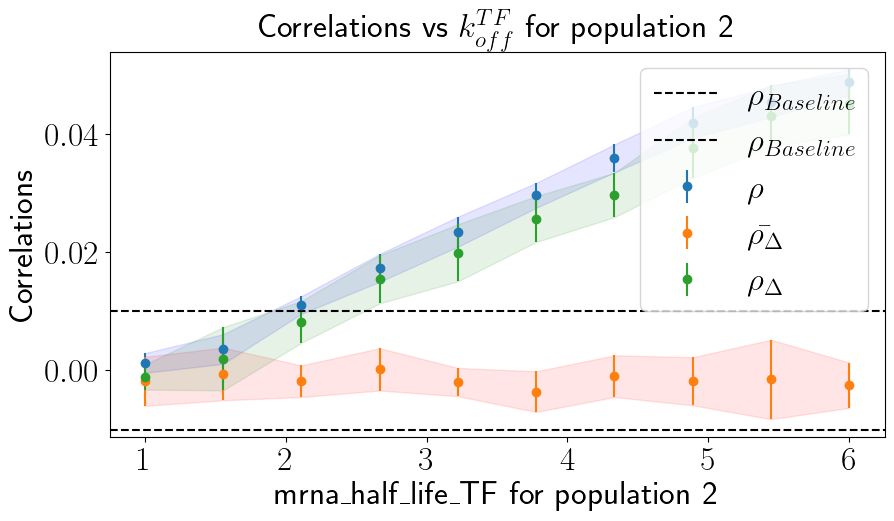

In [20]:
#Group runs together
df_grouped = df.groupby('mrna_half_life_TF').agg({'t1_gene_gene_correlation': ['mean', 'std'], 't1_random_pair_correlation': ['mean', 'std'], 't1_twin_pair_correlation': ['mean', 'std'], 'sigma_t1': ['mean', 'std'], 'sigma_bar_t1': ['mean', 'std']}).reset_index()
#Plot the mean and standard deviation of each group and colour between the 2 standard deviations
plt.figure(figsize=(10, 5))
plt.errorbar(df_grouped['mrna_half_life_TF'], df_grouped['t1_gene_gene_correlation']['mean'], yerr=df_grouped['t1_gene_gene_correlation']['std'], fmt='o', label=r'$\rho$')
plt.fill_between(df_grouped['mrna_half_life_TF'], df_grouped['t1_gene_gene_correlation']['mean'] - df_grouped['t1_gene_gene_correlation']['std'], df_grouped['t1_gene_gene_correlation']['mean'] + df_grouped['t1_gene_gene_correlation']['std'], alpha=0.1, color='blue')
plt.errorbar(df_grouped['mrna_half_life_TF'], df_grouped['t1_twin_pair_correlation']['mean'], yerr=df_grouped['t1_twin_pair_correlation']['std'], fmt='o', label=r'$\bar{\rho_{\Delta}}$')
plt.fill_between(df_grouped['mrna_half_life_TF'], df_grouped['t1_twin_pair_correlation']['mean'] - df_grouped['t1_twin_pair_correlation']['std'], df_grouped['t1_twin_pair_correlation']['mean'] + df_grouped['t1_twin_pair_correlation']['std'], alpha=0.1, color='red')
plt.errorbar(df_grouped['mrna_half_life_TF'], df_grouped['t1_random_pair_correlation']['mean'], yerr=df_grouped['t1_random_pair_correlation']['std'], fmt='o', label=r'$\rho_{\Delta}$')
plt.fill_between(df_grouped['mrna_half_life_TF'], df_grouped['t1_random_pair_correlation']['mean'] - df_grouped['t1_random_pair_correlation']['std'], df_grouped['t1_random_pair_correlation']['mean'] + df_grouped['t1_random_pair_correlation']['std'], alpha=0.1, color='green')
plt.xlabel(r'mrna_half_life_TF for population 2')
plt.ylabel('Correlations')
# plt.ylim(-0.01, 0.01)
# plt.yscale('log')
plt.axhline(0.01, color='black', linestyle='--', label=r'$\rho_{Baseline}$')
plt.axhline(-0.01, color='black', linestyle='--', label=r'$\rho_{Baseline}$')
plt.title('Correlations vs $k_{off}^{TF}$ for population 2')
plt.legend(loc = 'upper right')
plt.show()


# Analyze large-scale parameter scan


## First, open the parameter list file


In [3]:
parameter_df_orig = pd.read_csv('/home/mzo5929/Keerthana/grnInference/simulationData/parameters_25000.csv', index_col=0)


## Read the correlation data for a part of parameter set for original model


In [4]:
list_of_corr_files = os.listdir("/home/mzo5929/Keerthana/grnInference/simulationData/large_scale_parameter_scan/modified_regulation/")
print(len(list_of_corr_files))


24480


In [44]:
# #$Concat all csv files in the folder
# path_to_corr_folder =   "/home/mzo5929/Keerthana/grnInference/analysisData2/large_scale_parameter_scan/regulation/"
# list_of_corr_files = os.listdir(path_to_corr_folder)
corr_df = pd.concat([pd.read_csv(os.path.join(path_to_corr_folder, file)) for file in tqdm(list_of_corr_files) if file.endswith('.csv')], ignore_index=True)

  0%|          | 0/50 [00:00<?, ?it/s]

In [5]:
# corr_df.to_csv('/home/mzo5929/Keerthana/grnInference/analysisData2/large_scale_parameter_scan/correlation_df_large_scale_parameter_scan_regulation.csv', index=False)
corr_df = pd.read_csv('/home/mzo5929/Keerthana/grnInference/analysisData2/large_scale_parameter_scan/correlation_df_large_scale_parameter_scan_regulation.csv')

In [28]:
path_to_corr_no_reg_folder =  "/home/mzo5929/Keerthana/grnInference/analysisData2/large_scale_parameter_scan/no_regulation/"
list_of_corr_no_reg_files = os.listdir(path_to_corr_no_reg_folder)
corr_df_no_reg = pd.concat([pd.read_csv(os.path.join(path_to_corr_no_reg_folder, file)) for file in tqdm(list_of_corr_no_reg_files) if file.endswith('.csv')])

  0%|          | 0/50 [00:00<?, ?it/s]

In [30]:
corr_df_no_reg.to_csv('/home/mzo5929/Keerthana/grnInference/analysisData2/large_scale_parameter_scan/correlation_df_large_scale_parameter_scan_no_regulation.csv', index=False)

In [77]:
print(corr_df_no_reg[corr_df_no_reg['t1_gene_gene_correlation'] > 0.02].shape[0], corr_df_no_reg[corr_df_no_reg['t1_gene_gene_correlation'] < -0.02].shape[0])
corr_df_no_reg[corr_df_no_reg['t1_twin_pair_correlation'] > 0.01].shape[0], corr_df_no_reg[corr_df_no_reg['t1_twin_pair_correlation'] < -0.01].shape[0]

1 2


(1963, 1964)

In [84]:
print(corr_df[abs(corr_df['t1_gene_gene_correlation']) > 0.05].shape[0])
print(corr_df[(abs(corr_df['t1_twin_pair_correlation']) > 0.01) & (abs(corr_df['t1_gene_gene_correlation']) > 0.05)].shape[0])

16027
13785


In [85]:
print(corr_df_no_reg[abs(corr_df_no_reg['t1_gene_gene_correlation']) > 0.05].shape[0])
print(corr_df_no_reg[(abs(corr_df_no_reg['t1_twin_pair_correlation']) > 0.01) & (abs(corr_df_no_reg['t1_gene_gene_correlation']) > 0.05)].shape[0])

0
0


In [65]:
print(max(corr_df_no_reg['t1_gene_gene_correlation']))
print(min(corr_df_no_reg['t1_gene_gene_correlation']))

0.0225126039888352
-0.0212123644900455


In [6]:
# #$Concat all csv files in the folder
path_to_corr_mod_folder =  "/home/mzo5929/Keerthana/grnInference/analysisData2/large_scale_parameter_scan/modified_regulation/"
list_of_corr_mod_files = os.listdir(path_to_corr_mod_folder)
corr_df_mod = pd.concat([pd.read_csv(os.path.join(path_to_corr_mod_folder, file)) for file in tqdm(list_of_corr_mod_files) if file.endswith('.csv')])
# Keep only unique parameter index
corr_df_mod_read = pd.read_csv('/home/mzo5929/Keerthana/grnInference/analysisData2/large_scale_parameter_scan/correlation_df_large_scale_parameter_scan_modified_regulation.csv')
corr_df_mod = pd.concat([corr_df_mod_read, corr_df_mod], ignore_index=True)
corr_df_mod = corr_df_mod.drop_duplicates(subset=['parameter_index'])
corr_df_mod.to_csv('/home/mzo5929/Keerthana/grnInference/analysisData2/large_scale_parameter_scan/correlation_df_large_scale_parameter_scan_modified_regulation.csv', index=False)

  0%|          | 0/5 [00:00<?, ?it/s]

In [7]:
corr_df_mod

,parameter_index,t1_gene_gene_correlation,t1_twin_pair_correlation,t1_random_pair_correlation,t2_gene_gene_correlation,t2_twin_pair_correlation,t2_random_pair_correlation
0,8927,0.051645,0.002998,0.059441,0.047307,0.018888,0.047128
1,12008,0.107917,0.021195,0.097994,0.108361,0.066105,0.104627
2,10628,0.033106,0.010987,0.024003,0.044940,0.032859,0.038048
3,16807,0.051977,0.012003,0.050958,0.057358,0.031974,0.051845
4,15820,0.150403,0.033880,0.149630,0.150511,0.100185,0.148582
...,...,...,...,...,...,...,...
20835,18993,0.187082,0.043463,0.170571,0.177264,0.115036,0.169734
20836,14205,0.061618,0.012419,0.058530,0.061906,0.027864,0.053488
20837,14559,0.061573,0.002879,0.059087,0.062640,0.038139,0.046535
20838,19162,0.035000,0.010454,0.034863,0.040286,0.020855,0.036134


In [8]:
subset_indices = corr_df_mod['parameter_index'].unique()

In [9]:
len(subset_indices)

20840

In [10]:
corr_df_subset = corr_df[corr_df['parameter_index'].isin(subset_indices)]
# corr_df_subset = corr_df

In [32]:
corr_df_no_reg = corr_df_no_reg.sort_values(by='parameter_index')
corr_df = corr_df.sort_values(by='parameter_index')

In [35]:
corr_df.columns

Index(['parameter_index', 't1_gene_gene_correlation',
       't1_twin_pair_correlation', 't1_random_pair_correlation',
       't2_gene_gene_correlation', 't2_twin_pair_correlation',
       't2_random_pair_correlation'],
      dtype='object')

In [118]:
corr_df_filtered = corr_df[(corr_df['t1_gene_gene_correlation'] > 0.05) | (corr_df['t2_gene_gene_correlation'] > 0.05)]
print(corr_df_filtered.shape)
corr_df_filtered[((corr_df_filtered['t1_twin_pair_correlation']) > 0.01) | ((corr_df_filtered['t2_twin_pair_correlation']) > 0.01)]

(16609, 7)


,parameter_index,t1_gene_gene_correlation,t1_twin_pair_correlation,t1_random_pair_correlation,t2_gene_gene_correlation,t2_twin_pair_correlation,t2_random_pair_correlation
18432,0,0.078705,0.015196,0.060847,0.074441,0.033273,0.064067
15353,1,0.103597,0.013175,0.098431,0.108938,0.044361,0.106962
8661,3,0.110266,0.035563,0.096789,0.117377,0.094006,0.120298
8400,4,0.198561,0.041762,0.177312,0.191575,0.115397,0.175986
15527,5,0.058757,0.015743,0.055130,0.069439,0.034866,0.075207
...,...,...,...,...,...,...,...
5710,24995,0.081407,0.000394,0.080812,0.085088,0.044995,0.086351
20434,24996,0.067616,0.043460,0.058469,0.060600,0.067125,0.058361
10519,24997,0.119506,0.026944,0.115881,0.127212,0.087287,0.125838
11585,24998,0.192123,0.065696,0.178369,0.185297,0.156805,0.165970


In [119]:
corr_df_filtered[((corr_df_filtered['t1_twin_pair_correlation']) > 0.01)]

,parameter_index,t1_gene_gene_correlation,t1_twin_pair_correlation,t1_random_pair_correlation,t2_gene_gene_correlation,t2_twin_pair_correlation,t2_random_pair_correlation
18432,0,0.078705,0.015196,0.060847,0.074441,0.033273,0.064067
15353,1,0.103597,0.013175,0.098431,0.108938,0.044361,0.106962
8661,3,0.110266,0.035563,0.096789,0.117377,0.094006,0.120298
8400,4,0.198561,0.041762,0.177312,0.191575,0.115397,0.175986
15527,5,0.058757,0.015743,0.055130,0.069439,0.034866,0.075207
...,...,...,...,...,...,...,...
13166,24994,0.057042,0.022345,0.048273,0.055689,0.054074,0.040954
20434,24996,0.067616,0.043460,0.058469,0.060600,0.067125,0.058361
10519,24997,0.119506,0.026944,0.115881,0.127212,0.087287,0.125838
11585,24998,0.192123,0.065696,0.178369,0.185297,0.156805,0.165970


(25000, 7)
(0, 7)


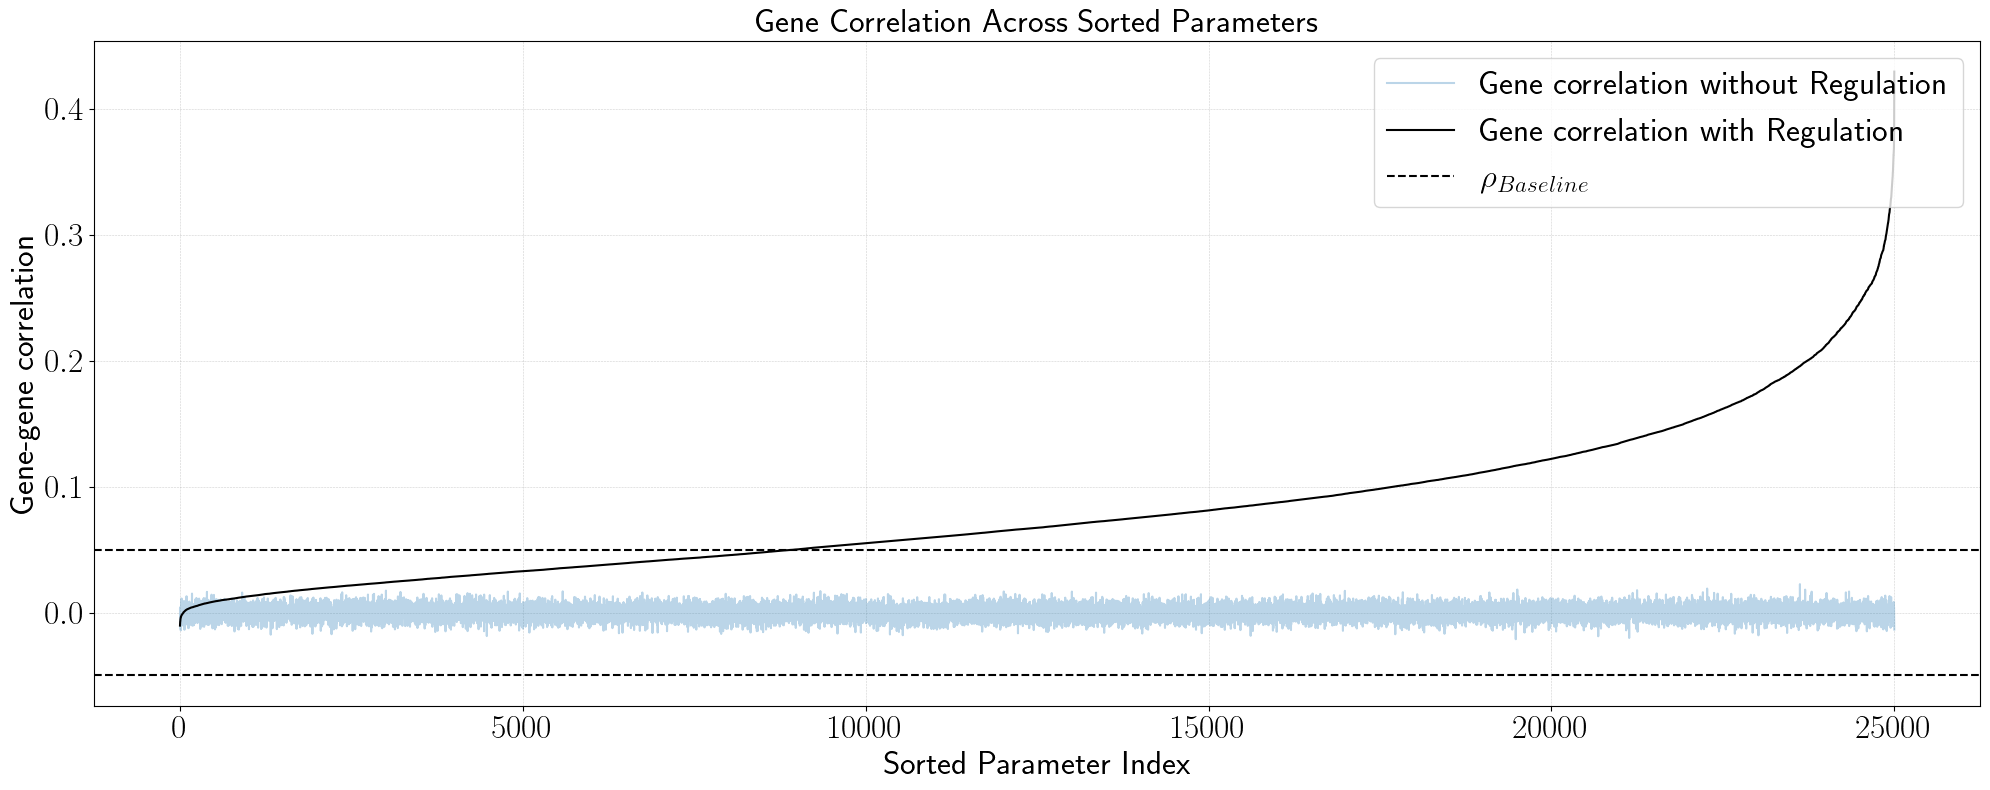

In [159]:
# Step 1: Sort with-regulation df by correlation value
# Step 1: Filter the DataFrame based on the condition
# corr_df_filtered = corr_df[corr_df['t1_gene_gene_correlation'] > 0.05].copy()

# Step 2: Sort the filtered DataFrame by correlation value
corr_df_sorted = corr_df_filtered.sort_values(by='t1_gene_gene_correlation').reset_index(drop=True)
print(corr_df_sorted.shape)

# Step 3: Get the sorted parameter index order
sorted_param_indices = corr_df_sorted['parameter_index'].values

# Step 4: Reindex both dataframes
corr_df_no_reg_sorted = corr_df_no_reg_sorted[corr_df_no_reg_sorted['t1_gene_gene_correlation'] > 0.05]
print(corr_df_no_reg_sorted.shape)
corr_df_no_reg_sorted = corr_df_no_reg.set_index('parameter_index').loc[sorted_param_indices].reset_index()
corr_df_sorted['parameter_index'] = np.arange(len(corr_df_sorted))  # Reset x-axis to be sorted index
corr_df_no_reg_sorted['parameter_index'] = np.arange(len(corr_df_no_reg_sorted))

# Step 5: Plot
plt.figure(figsize=(20, 8))

# plt.plot(corr_df_sorted['parameter_index'], corr_df_sorted['t1_gene_gene_correlation'], alpha=0.3, label='Gene-Gene Correlation With Regulation')
plt.plot(corr_df_no_reg_sorted['parameter_index'], corr_df_no_reg_sorted['t1_gene_gene_correlation'], alpha=0.3, label='Gene correlation without Regulation')
plt.plot(corr_df_sorted['parameter_index'], corr_df_sorted['t1_gene_gene_correlation'], alpha=1, label='Gene correlation with Regulation', linewidth = 1.5, color = "black")

plt.xlabel('Sorted Parameter Index')
plt.ylabel(r'Gene-gene correlation')
plt.title('Gene Correlation Across Sorted Parameters')

plt.axhline(5e-2, color='black', linestyle='--', label=r'$\rho_{Baseline}$')
plt.axhline(-5e-2, color='black', linestyle='--')
# plt.yscale('log')
plt.legend(loc='upper right')
plt.grid(True, linestyle='--', linewidth=0.4, alpha=0.6)
plt.tight_layout()
plt.show()


In [143]:
# selected_indices = corr_df_subset[(abs(corr_df_subset['t1_gene_gene_correlation']) > 0.05) & (corr_df_subset['t1_twin_pair_correlation'] < 0.01)]['parameter_index'].tolist()
# selected_indices = corr_df_subset[(abs(corr_df_subset['t2_gene_gene_correlation']) < 0.05)]['parameter_index'].tolist()
selected_indices = corr_df_subset[(abs(corr_df_subset['t1_gene_gene_correlation']) > 0.05)]['parameter_index'].tolist()
len(selected_indices)

13334

In [66]:
selected_indices_mod = corr_df_mod[(abs(corr_df_mod['t2_gene_gene_correlation']) < 0.05)]['parameter_index'].tolist()
# selected_indices_mod = corr_df_mod[(abs(corr_df_mod['t2_gene_gene_correlation']) > 0.05) & (corr_df_mod['t2_twin_pair_correlation'] < 0.01)]['parameter_index'].tolist()
len(selected_indices_mod)

6007

In [21]:
parameter_df = parameter_df_orig.loc[corr_df_subset['parameter_index'].tolist()]
parameter_df["mRNA_to_protein_deg_ratio"] = parameter_df["mrna_half_life_TF"] / parameter_df["protein_half_life"]
parameter_df_mod = parameter_df_orig.loc[corr_df_mod['parameter_index'].tolist()]
parameter_df_mod["mRNA_to_protein_deg_ratio"] = parameter_df_mod["mrna_half_life_TF"] / parameter_df_mod["protein_half_life"]

In [144]:
selected_params = parameter_df_orig.iloc[selected_indices]
selected_params["mRNA_to_protein_deg_ratio"] = selected_params["mrna_half_life_TF"] / selected_params["protein_half_life"]
selected_params

/tmp/ipykernel_720855/304515986.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_params["mRNA_to_protein_deg_ratio"] = selected_params["mrna_half_life_TF"] / selected_params["protein_half_life"]


,k_on_TF,k_off_TF,burst_size_TF,k_on_Target,k_off_Target,burst_size_Target,mrna_half_life_TF,mrna_half_life_Target,protein_half_life,protein_production_rate,n,splicing_half_life_minutes,labeling_efficiency,pulse_time,num_cells,dynamics,capture_efficiency,mRNA_to_protein_deg_ratio
17855,0.299223,72.755509,45.652840,0.461049,43.785410,70.426765,3.564732,4.017185,82.424697,0.293191,4.585031,7,1,60,20000,MM,1,0.043248
1522,0.160524,18.572664,15.318740,0.216641,39.982893,43.401952,4.697364,2.892197,80.210765,0.244521,2.449731,7,1,60,20000,MM,1,0.058563
21042,0.345740,45.052377,62.546632,0.480732,31.771584,44.879067,1.329023,1.795754,43.993280,0.275165,4.180308,7,1,60,20000,MM,1,0.030210
20470,0.437645,78.033112,47.189742,0.233931,70.564602,66.824581,5.053365,3.889043,22.677708,0.157387,3.181848,7,1,60,20000,MM,1,0.222834
2337,0.227384,23.006223,20.580609,0.207280,10.792600,47.573062,4.916000,2.181676,79.369447,0.103332,4.984535,7,1,60,20000,MM,1,0.061938
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8234,0.382195,21.413112,45.022823,0.483415,73.965197,56.703903,5.992810,2.439878,13.825888,0.173209,4.009173,7,1,60,20000,MM,1,0.433448
9176,0.288635,53.538172,48.474837,0.416831,56.117653,35.869435,1.212028,1.355702,13.801304,0.302743,4.592019,7,1,60,20000,MM,1,0.087820
5195,0.434595,77.614468,54.453298,0.332894,4.609000,18.698028,4.776274,1.029059,84.467687,0.253181,3.212246,7,1,60,20000,MM,1,0.056546
8759,0.247874,17.389713,27.658083,0.195926,46.610901,74.333171,5.273095,2.454216,42.567918,0.274089,1.956096,7,1,60,20000,MM,1,0.123875


In [68]:
selected_params_mod = parameter_df_orig.iloc[selected_indices_mod]
selected_params_mod["mRNA_to_protein_deg_ratio"] = selected_params_mod["mrna_half_life_TF"] / selected_params_mod["protein_half_life"]
selected_params_mod

/tmp/ipykernel_1474413/1949746916.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_params_mod["mRNA_to_protein_deg_ratio"] = selected_params_mod["mrna_half_life_TF"] / selected_params_mod["protein_half_life"]


,k_on_TF,k_off_TF,burst_size_TF,k_on_Target,k_off_Target,burst_size_Target,mrna_half_life_TF,mrna_half_life_Target,protein_half_life,protein_production_rate,n,splicing_half_life_minutes,labeling_efficiency,pulse_time,num_cells,dynamics,capture_efficiency,mRNA_to_protein_deg_ratio
8927,0.364933,27.697790,45.097843,0.346144,40.102637,59.015733,4.738068,3.454501,86.965707,0.274460,1.733903,7,1,60,20000,MM,1,0.054482
10628,0.139821,18.445936,36.289069,0.336332,1.823542,78.802480,1.580629,5.481854,34.722374,0.253645,1.156149,7,1,60,20000,MM,1,0.045522
12966,0.407529,19.239525,50.287035,0.319428,70.590802,71.512199,1.147549,4.142453,72.953777,0.185037,4.814613,7,1,60,20000,MM,1,0.015730
23477,0.327601,48.755664,63.148765,0.177959,9.581232,64.845384,3.139448,5.218770,81.051118,0.318713,2.687286,7,1,60,20000,MM,1,0.038734
10428,0.306085,12.566313,39.489395,0.449914,39.747264,49.646912,2.647585,2.237918,86.843828,0.020349,1.208723,7,1,60,20000,MM,1,0.030487
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23665,0.289393,59.980207,61.503562,0.184782,9.207898,54.592973,5.063785,2.202415,86.421001,0.174783,0.713336,7,1,60,20000,MM,1,0.058594
24343,0.195470,55.614285,62.716390,0.239754,5.960431,16.184358,2.049221,1.371005,17.683896,0.036832,0.679435,7,1,60,20000,MM,1,0.115881
14290,0.499070,59.846492,38.687473,0.213542,62.678482,17.368002,1.283060,3.312816,54.601663,0.217778,1.584862,7,1,60,20000,MM,1,0.023499
14759,0.394067,3.435204,41.136867,0.283764,4.289838,74.026811,4.950061,5.936121,54.162250,0.244588,1.215671,7,1,60,20000,MM,1,0.091393


In [96]:
selected_params_mod.columns

Index(['k_on_TF', 'k_off_TF', 'burst_size_TF', 'k_on_Target', 'k_off_Target',
       'burst_size_Target', 'mrna_half_life_TF', 'mrna_half_life_Target',
       'protein_half_life', 'protein_production_rate', 'n',
       'splicing_half_life_minutes', 'labeling_efficiency', 'pulse_time',
       'num_cells', 'dynamics', 'capture_efficiency',
       'mRNA_to_protein_deg_ratio'],
      dtype='object')

In [138]:
corr_df

,parameter_index,t1_gene_gene_correlation,t1_twin_pair_correlation,t1_random_pair_correlation,t2_gene_gene_correlation,t2_twin_pair_correlation,t2_random_pair_correlation
18432,0,0.078705,0.015196,0.060847,0.074441,0.033273,0.064067
15353,1,0.103597,0.013175,0.098431,0.108938,0.044361,0.106962
23431,2,0.021918,0.002764,0.029315,0.017872,0.010309,0.009850
8661,3,0.110266,0.035563,0.096789,0.117377,0.094006,0.120298
8400,4,0.198561,0.041762,0.177312,0.191575,0.115397,0.175986
...,...,...,...,...,...,...,...
5710,24995,0.081407,0.000394,0.080812,0.085088,0.044995,0.086351
20434,24996,0.067616,0.043460,0.058469,0.060600,0.067125,0.058361
10519,24997,0.119506,0.026944,0.115881,0.127212,0.087287,0.125838
11585,24998,0.192123,0.065696,0.178369,0.185297,0.156805,0.165970


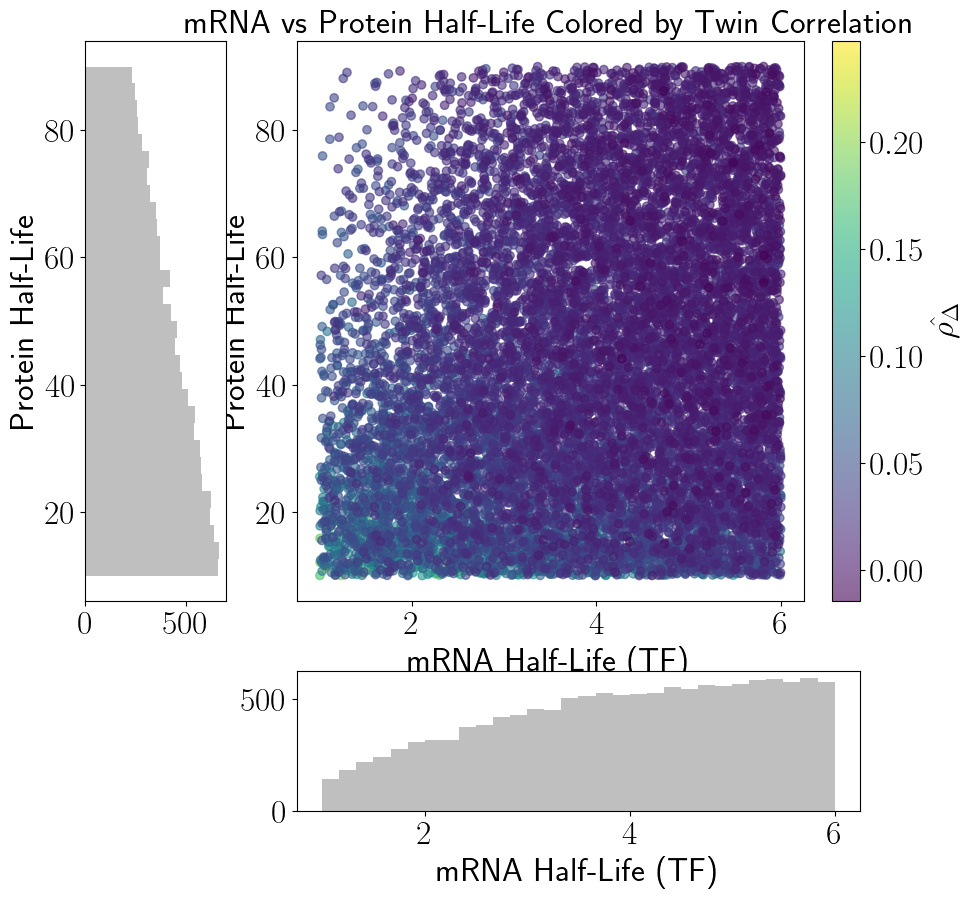

In [145]:
# Merge correlation values (as before)
selected_params = selected_params.copy()
selected_params['param_index'] = selected_params.index
selected_with_corr = selected_params.merge(
    corr_df[['parameter_index', 't1_twin_pair_correlation']],
    left_on='param_index', right_on='parameter_index'
)

# Sort for plotting: high correlation first, low correlation last (on top)
selected_with_corr = selected_with_corr.sort_values(by='t1_twin_pair_correlation', ascending=False)

# Plot
fig = plt.figure(figsize=(10, 10))
grid = plt.GridSpec(4, 4, hspace=0.5, wspace=0.5)

main_ax = fig.add_subplot(grid[:-1, 1:])
x_hist = fig.add_subplot(grid[:-1, 0], sharey=main_ax)
y_hist = fig.add_subplot(grid[-1, 1:], sharex=main_ax)

# Scatter plot (low-correlation points on top)
sc = main_ax.scatter(
    selected_with_corr['mrna_half_life_TF'],
    selected_with_corr['protein_half_life'],
    c=selected_with_corr['t1_twin_pair_correlation'],
    cmap='viridis',
    alpha=0.6
)

main_ax.set_xlabel('mRNA Half-Life (TF)')
main_ax.set_ylabel('Protein Half-Life')
main_ax.set_title('mRNA vs Protein Half-Life Colored by Twin Correlation')

# Colorbar
cbar = fig.colorbar(sc, ax=main_ax, orientation='vertical', fraction=0.05)
cbar.set_label(r'$\hat{\rho_{\Delta}}$')

# Histograms
x_hist.hist(selected_with_corr['protein_half_life'], bins=30, orientation='horizontal', color='grey', alpha=0.5)
x_hist.set_ylabel('Protein Half-Life')

y_hist.hist(selected_with_corr['mrna_half_life_TF'], bins=30, orientation='vertical', color='grey', alpha=0.5)
y_hist.set_xlabel('mRNA Half-Life (TF)')

plt.show()


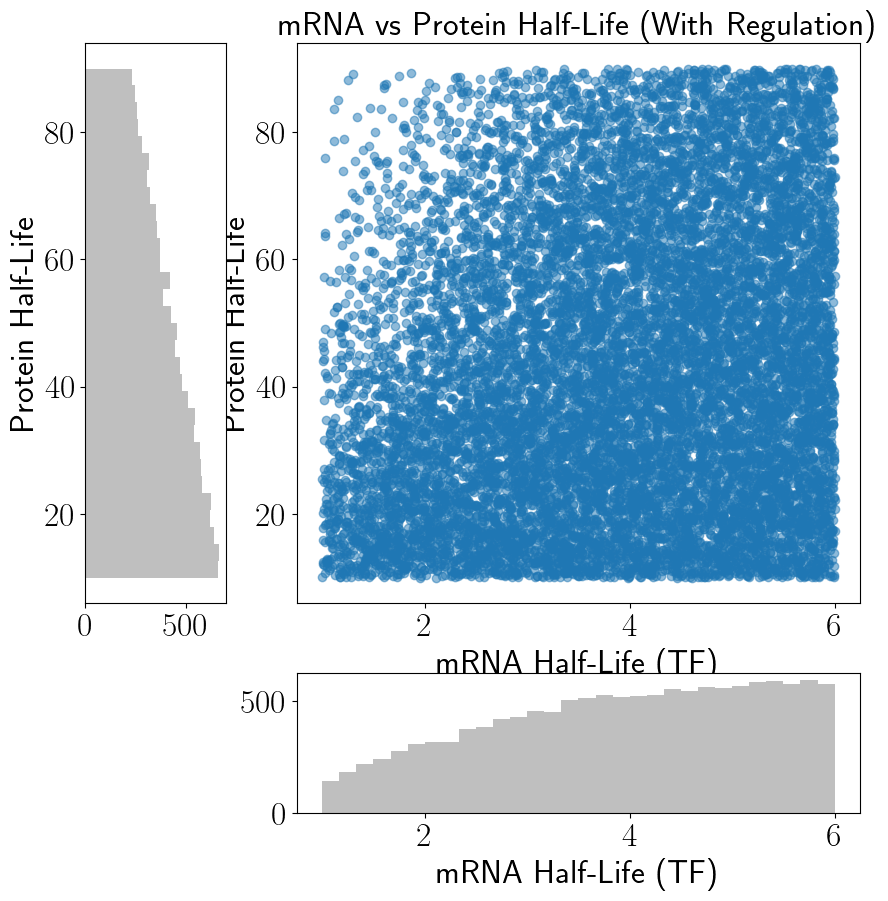

In [146]:
# Create a scatter plot with histograms

fig = plt.figure(figsize=(10, 10))
grid = plt.GridSpec(4, 4, hspace=0.5, wspace=0.5)

main_ax = fig.add_subplot(grid[:-1, 1:])
x_hist = fig.add_subplot(grid[:-1, 0], sharey=main_ax)
y_hist = fig.add_subplot(grid[-1, 1:], sharex=main_ax)

# Scatter plot
main_ax.scatter(selected_params['mrna_half_life_TF'], selected_params['protein_half_life'], alpha=0.5)
main_ax.set_xlabel('mRNA Half-Life (TF)')
main_ax.set_ylabel('Protein Half-Life')
main_ax.set_title('mRNA vs Protein Half-Life (With Regulation)')

# Histogram for mRNA Half-Life (TF)
x_hist.hist(selected_params['protein_half_life'], bins=30, orientation='horizontal', color='grey', alpha=0.5)
x_hist.set_ylabel('Protein Half-Life')

# Histogram for Protein Half-Life
y_hist.hist(selected_params['mrna_half_life_TF'], bins=30, orientation='vertical', color='grey', alpha=0.5)
y_hist.set_xlabel('mRNA Half-Life (TF)')

plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
#Remove not useful columns
selected_params_mod = selected_params_mod.drop(columns=['splicing_half_life_minutes', 'labeling_efficiency', 'pulse_time',
       'num_cells', 'dynamics', 'capture_efficiency'])

for col in selected_params_mod.columns:
    if col == "dynamics":
        continue
    plt.figure(figsize=(10, 5))
    # --- Ensure numeric ---
    baseline_vals = pd.to_numeric(parameter_df_mod[col], errors='coerce').dropna()
    selected_vals = pd.to_numeric(selected_params_mod[col], errors='coerce').dropna()

    # --- Shared bins from combined data (optional, for alignment) ---
    combined_vals = np.concatenate([baseline_vals, selected_vals])
    bins = np.histogram_bin_edges(combined_vals, bins=50)

    # --- Baseline histogram ---
    baseline_counts, _ = np.histogram(baseline_vals, bins=bins)
    baseline_frac = baseline_counts / baseline_counts.sum()
    plt.bar(bins[:-1], baseline_frac, width=np.diff(bins), alpha=0.3, color='black', label='Baseline', align='edge')

    # --- Selected histogram ---
    selected_counts, _ = np.histogram(selected_vals, bins=bins)
    selected_frac = selected_counts / selected_counts.sum()
    plt.bar(bins[:-1], selected_frac, width=np.diff(bins), alpha=0.5, label='Selected', align='edge')

    plt.xlabel(col)
    plt.ylabel('Fraction of Samples')
    plt.title(f'Normalized Histogram of {col}')
    plt.legend()
    plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.6)
    plt.show()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

print(selected_params.shape)
# selected_params = selected_params.drop(columns=['splicing_half_life_minutes', 'labeling_efficiency', 'pulse_time',
#        'num_cells', 'dynamics', 'capture_efficiency'])
for col in selected_params.columns:
    if col == "dynamics":
        continue
    plt.figure(figsize=(15, 8))

    # --- Ensure numeric ---
    baseline_vals = pd.to_numeric(parameter_df[col], errors='coerce').dropna()
    selected_vals = pd.to_numeric(selected_params[col], errors='coerce').dropna()

    # --- Shared bins from combined data (optional, for alignment) ---
    combined_vals = np.concatenate([baseline_vals, selected_vals])
    bins = np.histogram_bin_edges(combined_vals, bins=30)

    # --- Baseline histogram ---
    baseline_counts, _ = np.histogram(baseline_vals, bins=bins)
    baseline_frac = baseline_counts / baseline_counts.sum()
    plt.bar(bins[:-1], baseline_frac, width=np.diff(bins), alpha=0.3, color='black', label='All parameters', align='edge')

    # --- Selected histogram ---
    selected_counts, _ = np.histogram(selected_vals, bins=bins)
    selected_frac = selected_counts / selected_counts.sum()
    plt.bar(bins[:-1], selected_frac, width=np.diff(bins), alpha=0.5, label='No twin correlation', align='edge', color = "brown")

    plt.xlabel(col)
    plt.ylabel('Fraction of Samples')
    plt.title(f'Normalized Histogram of {col}')
    plt.legend()
    plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.6)
    plt.show()


In [71]:
modified_df = pd.read_csv('/home/mzo5929/Keerthana/grnInference/analysisData2/large_scale_parameter_scan/modified_regulation/partial_000.csv')

In [77]:
modified_df

,parameter_index,t1_gene_gene_correlation,t1_twin_pair_correlation,t1_random_pair_correlation,t2_gene_gene_correlation,t2_twin_pair_correlation,t2_random_pair_correlation
0,13505,0.050050,0.014501,0.049109,0.056358,0.031895,0.047509
1,19196,0.077898,0.019647,0.077371,0.066663,0.053586,0.079276
2,18338,0.129533,0.012703,0.132025,0.136757,0.073276,0.133921
3,24105,0.041515,0.000027,0.037634,0.047602,0.017447,0.035219
4,15282,0.090060,0.005231,0.086310,0.086513,0.030765,0.093758
5,22932,0.103863,0.020171,0.100044,0.100074,0.048999,0.095988
6,21675,0.060251,0.003300,0.052939,0.058225,0.020641,0.053892
7,16863,0.135646,0.029816,0.134543,0.140367,0.068196,0.141272
8,15793,0.077388,0.006429,0.083716,0.084727,0.045736,0.083135
9,11783,0.046211,0.008520,0.042799,0.058265,0.046856,0.047815


In [84]:
twin_was_less = modified_df[:10] #First 10 rows
twin_was_less = twin_was_less[(twin_was_less['t1_gene_gene_correlation']) > 0.05]
twin_was_less

,parameter_index,t1_gene_gene_correlation,t1_twin_pair_correlation,t1_random_pair_correlation,t2_gene_gene_correlation,t2_twin_pair_correlation,t2_random_pair_correlation
0,13505,0.050050,0.014501,0.049109,0.056358,0.031895,0.047509
1,19196,0.077898,0.019647,0.077371,0.066663,0.053586,0.079276
2,18338,0.129533,0.012703,0.132025,0.136757,0.073276,0.133921
4,15282,0.090060,0.005231,0.086310,0.086513,0.030765,0.093758
5,22932,0.103863,0.020171,0.100044,0.100074,0.048999,0.095988
6,21675,0.060251,0.003300,0.052939,0.058225,0.020641,0.053892
7,16863,0.135646,0.029816,0.134543,0.140367,0.068196,0.141272
8,15793,0.077388,0.006429,0.083716,0.084727,0.045736,0.083135


# Analyzing two state populations


In [1]:
parameter_df_orig = pd.read_csv('/home/mzo5929/Keerthana/grnInference/simulationData/parameters_25000.csv', index_col=0)

NameError: name 'pd' is not defined

In [ ]:
# #$Concat all csv files in the folder
path_to_corr_mod_folder =  "/home/mzo5929/Keerthana/grnInference/analysisData2/large_scale_parameter_scan/modified_regulation/"
list_of_corr_mod_files = os.listdir(path_to_corr_mod_folder)
corr_df_mod = pd.concat([pd.read_csv(os.path.join(path_to_corr_mod_folder, file)) for file in tqdm(list_of_corr_mod_files) if file.endswith('.csv')])
# Keep only unique parameter index
corr_df_mod_read = pd.read_csv('/home/mzo5929/Keerthana/grnInference/analysisData2/large_scale_parameter_scan/correlation_df_large_scale_parameter_scan_modified_regulation.csv')
corr_df_mod = pd.concat([corr_df_mod_read, corr_df_mod], ignore_index=True)
corr_df_mod = corr_df_mod.drop_duplicates(subset=['parameter_index'])
corr_df_mod.to_csv('/home/mzo5929/Keerthana/grnInference/analysisData2/large_scale_parameter_scan/correlation_df_large_scale_parameter_scan_modified_regulation.csv', index=False)

In [ ]:
# Step 1: Sort with-regulation df by correlation value
# Step 1: Filter the DataFrame based on the condition
# corr_df_filtered = corr_df[corr_df['t1_gene_gene_correlation'] > 0.05].copy()

# Step 2: Sort the filtered DataFrame by correlation value
corr_df_sorted = corr_df_filtered.sort_values(by='t1_gene_gene_correlation').reset_index(drop=True)
print(corr_df_sorted.shape)

# Step 3: Get the sorted parameter index order
sorted_param_indices = corr_df_sorted['parameter_index'].values

# Step 4: Reindex both dataframes
corr_df_no_reg_sorted = corr_df_no_reg_sorted[corr_df_no_reg_sorted['t1_gene_gene_correlation'] > 0.05]
print(corr_df_no_reg_sorted.shape)
corr_df_no_reg_sorted = corr_df_no_reg.set_index('parameter_index').loc[sorted_param_indices].reset_index()
corr_df_sorted['parameter_index'] = np.arange(len(corr_df_sorted))  # Reset x-axis to be sorted index
corr_df_no_reg_sorted['parameter_index'] = np.arange(len(corr_df_no_reg_sorted))

# Step 5: Plot
plt.figure(figsize=(20, 8))

# plt.plot(corr_df_sorted['parameter_index'], corr_df_sorted['t1_gene_gene_correlation'], alpha=0.3, label='Gene-Gene Correlation With Regulation')
plt.plot(corr_df_no_reg_sorted['parameter_index'], corr_df_no_reg_sorted['t1_gene_gene_correlation'], alpha=0.3, label='Gene correlation without Regulation')
plt.plot(corr_df_sorted['parameter_index'], corr_df_sorted['t1_gene_gene_correlation'], alpha=1, label='Gene correlation with Regulation', linewidth = 1.5, color = "black")

plt.xlabel('Sorted Parameter Index')
plt.ylabel(r'Gene-gene correlation')
plt.title('Gene Correlation Across Sorted Parameters')

plt.axhline(5e-2, color='black', linestyle='--', label=r'$\rho_{Baseline}$')
plt.axhline(-5e-2, color='black', linestyle='--')
# plt.yscale('log')
plt.legend(loc='upper right')
plt.grid(True, linestyle='--', linewidth=0.4, alpha=0.6)
plt.tight_layout()
plt.show()
